# Behavior

In [ ]:
## Pandas 
import pandas as pd
import numpy as np
import seaborn as sns # Alternativa pra gerar gráficos
from sklearn.cluster import KMeans ## Agrupamento pela média das variáveis
from sklearn.metrics import silhouette_score # Método para encontrat n° ideal de grupos
from sklearn.preprocessing import OrdinalEncoder # codificar variaveis categoricas
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer # Método k vizinhos mais proximos
from sklearn.preprocessing import StandardScaler # Padronizar dados
from dfply import *
import joblib ## Salvar modelo como pickle
from sklearn.impute import SimpleImputer # imputação simples
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold ### funcionalidadde para separar os dados em treino e teste
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF
from scipy.stats import skew ## Assimetria  -- Para os modelos o ideal é ter preditores com pouca assimetria, mas isso não é extremamente importante
from sklearn.feature_selection import VarianceThreshold # Variancia nula -- Verifica se alguma variável tem variancia nula - O ideal é que não tenha esse tipo de variável nas com as preditoras pois elas não representam a variabilidade dos dados

#%pip install imbalanced-learn
#superamostragem  e subamostragem
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler

# modelo de XGBoost
#!pip install xgboost
import xgboost  as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# modelo de Regressão Logística
from sklearn.linear_model import LogisticRegression

# comparação de modelos
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve , auc, mean_squared_error, mean_absolute_error,recall_score,precision_score

##Visualização data frame pandas sem truncamento
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', None)

# permite a vizualiçaõ de números flutuantes com duas casas decimais
pd.set_option('display.float_format', '{:.2f}'.format)
np.random.seed(100)

## Contratos Carnê

In [215]:
# Base Carnê
# Apenas um arquivo
caminho= "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos Carne/banco de dados/contratos_carne.csv"
df_carne = pd.read_csv(
    caminho,
    sep=";"
)

# Trocando datas no formato brasileiro para o formato americano
mascara_dmy = df_carne["data"].str.contains(r"^\d{2}/\d{2}/\d{4}$", na=False)
df_carne.loc[mascara_dmy, "data"] = pd.to_datetime(
    df_carne.loc[mascara_dmy, "data"], dayfirst=True
).dt.strftime("%Y-%m-%d")

mascara_data_venc = df_carne["data_vencimento_ultima_parcela"].str.contains(r"^\d{2}/\d{2}/\d{4}$", na=False)
df_carne.loc[mascara_data_venc, "data_vencimento_ultima_parcela"] = pd.to_datetime(
    df_carne.loc[mascara_data_venc, "data_vencimento_ultima_parcela"], dayfirst=True
).dt.strftime("%Y-%m-%d")

mascara_data_prox = df_carne["data_vencimento_prox_parcela"].str.contains(r"^\d{2}/\d{2}/\d{4}$", na=False)
df_carne.loc[mascara_data_prox, "data_vencimento_prox_parcela"] = pd.to_datetime(
    df_carne.loc[mascara_data_prox, "data_vencimento_prox_parcela"], dayfirst=True
).dt.strftime("%Y-%m-%d")

# Excluindo Espaços em branco à esquerda e direita
df_carne["id_agente"] = df_carne["id_agente"].str.strip()

# % de nulos por linha
df_carne["%_nulos"] = df_carne.isna().sum(axis=1) / df_carne.shape[1] * 100

# Excluindo linhas
to_exclude = [
    "033 VENDAS ATACADO",
    "009 SAQUE EMERGENCIAL",
    "029 RENEGOCIACAO SAQUE EMER (AG19)",
    "019 RENEGOCIACAO SAQUE EMERGENCIAL"
]
df_carne = df_carne[
    ~df_carne["id_agente"].isin(to_exclude) &
    (df_carne["%_nulos"] <= 50)
].drop(columns=["%_nulos"])

#Tipos
tipos_carne = {
    "conceito": "string",
    "id_financeira": "string"
}

# conversão
df_carne = df_carne.astype({k: v for k, v in tipos_carne.items()})

# colunas de datas
df_carne["data_vencimento_prox_parcela"] = pd.to_datetime(df_carne["data_vencimento_prox_parcela"], errors="coerce")
df_carne["data_vencimento_ultima_parcela"] = pd.to_datetime(df_carne["data_vencimento_ultima_parcela"], errors="coerce")
df_carne["data"] = pd.to_datetime(df_carne["data"], errors="coerce")

# Categorização 'Produto'
condicoes = [
    df_carne["id_agente"] == "001 CREDIARIO",
    df_carne["id_agente"] == "004 KREDILIG (CDC)",
    df_carne["id_agente"] == "005 KREDILIG (CP)",
    df_carne["id_agente"] == "044 SEGURO - KREDILIG (CDC)",
    df_carne["id_agente"].isin([
        "011 RENEGOCIACAO CREDIARIO",
        "021 RENEGOCIACAO CREDIARIO (AG 11)",
        "014 RENEGOCIACAO CDC",
        "024 RENEGOCIACAO CDC (AG 14)",
        "015 RENEGOCIACAO CP",
        "025 RENEGOCIACAO CP (AG 15)"
    ])
]

prod = ["CREDIARIO", "CDC", "CP", "CDC", "RENEG_CARNE"]
df_carne["Produto"] = np.select(condicoes, prod, default="SEM CLASSIFICACAO")

# Criar novas variáveis, resumir
cols_a_vencer = [
    "creditos_a_vencer_ate_30_dias",
    "creditos_a_vencer_de_31_e_60_dias",
    "creditos_a_vencer_de_61_e_90_dias",
    "creditos_a_vencer_de_91_e_180_dias",
    "creditos_a_vencer_de_181_e_360_dias",
    "creditos_a_vencer_de_361_e_720_dias",
    "creditos_a_vencer_de_721_e_1080_dias",
    "creditos_a_vencer_de_1081_e_1440_dias",
    "creditos_a_vencer_de_1441_e_1800_dias",
    "creditos_a_vencer_de_1801_e_5400_dias",
    "creditos_a_vencer_acima_de_5400_dias"
]

cols_vencidos = [
    "creditos_vencidos_de_1_a_14_dias",
    "creditos_vencidos_de_15_a_30_dias",
    "creditos_vencidos_de_31_a_60_dias",
    "creditos_vencidos_de_61_a_90_dias",
    "creditos_vencidos_de_91_a_120_dias",
    "creditos_vencidos_de_121_a_150_dias",
    "creditos_vencidos_de_151_a_180_dias",
    "creditos_vencidos_de_181_a_240_dias",
    "creditos_vencidos_de_241_a_300_dias",
    "creditos_vencidos_de_301_a_360_dias",
    "creditos_vencidos_de_361_a_540_dias",
    "creditos_vencidos_acima_de_540_dias"
]

df_carne["Creditos_a_vencer"] = df_carne[cols_a_vencer].sum(axis=1)# soma das colunas crédito a vencer
df_carne["creditos_vencidos"] = df_carne[cols_vencidos].sum(axis=1)# soma das colunas crédito vencidos

# criando indicadoras

df_carne["ind_reneg"] = (df_carne["flag_renegociacao"] == "SIM").astype(int) # Indicador numérico de contratos de Renegociação
df_carne["valor_da_parcela_aberto"] = np.where(df_carne["saldo_contabil"] > 0, df_carne["valor_parcela"], 0)# Variável contém apenas os valores das parcelas mensais em aberto
df_carne["valor_principal_total_aberto"] = np.where(df_carne["saldo_contabil"] > 0, df_carne["principal_total"], 0)# Variável possui apenas o valor total principal aberto
#df_carne["ind_seguro"] = (df_carne["Produto"] == "SEGURO").astype(int) # indicador se é um contrato de seguro
#df_carne["valor_seguro"] = np.where(df_carne["Produto"] == "SEGURO", df_carne["principal_total"], 0) # valore do seguro

for var in ["taxajuros", "cet", "qtd_parcelas_pagas", "dias_carencia"]:
    df_carne[var] = df_carne[var].clip(lower=0) # negativos são substituídos por zero

df_carne["principal_total"] = np.where(df_carne["principal_total"] > 0,
                                  df_carne["principal_total"],
                                  df_carne["valor_pago"]) # substituir valores negativos pelo valor pago

# Drop das colunas valores vencidos e a vencer
df_carne = df_carne.drop(columns=cols_a_vencer + cols_vencidos + ["anomes_new"])

# info
#df_carne.info()
#df_carne.head()

## Contratos Cartão

In [230]:
## Base cartões 

arquivos_cartao = [
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2015.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2016.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2017.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2018.csv",    
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2019.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2020.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2021.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2022.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2023.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2024.csv",
    "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos_2025.csv"]

df_list = [
    pd.read_csv(f, sep=";")
    for f in arquivos_cartao
]

df_cartao = pd.concat(df_list, ignore_index=True)

# For para trocar , por . em colunas numéricas
# colunas numéricas
col_numerica_cartao=[
#"CPF_CNPJ",
#"NUMERO_CONTRATO",
"DIAS_CARENCIA",
"TAXA_JUROS",
"CET",
"SALDO_CONTABIL",
"DIAS_MAIOR_ATRASO_ABERTO",
"DIAS_MAIOR_ATRASO",
"MEDIA_ATRASO",
"QTD_PARCELAS",
"QTD_PARCELAS_ABERTAS",
"QTD_PARCELAS_PAGAS",
"VALOR_PAGO",
"JUROS_PAGOS_ATRASO",
"VALOR_PARCELA",
"VALOR_CALCULADO",
"VALOR_DESCONTO",
"PRINCIPAL_TOTAL",
"VALOR_FINANCIADO",
"CREDITOS_A_VENCER_ATE_30_DIAS",
"CREDITOS_A_VENCER_DE_31_A_60_DIAS",
"CREDITOS_A_VENCER_DE_61_A_90_DIAS",
"CREDITOS_A_VENCER_DE_91_A_180_DIAS",
"CREDITOS_A_VENCER_DE_181_A_360_DIAS",
"CREDITOS_A_VENCER_DE_361_A_720_DIAS",
"CREDITOS_A_VENCER_DE_721_A_1080_DIAS",
"CREDITOS_A_VENCER_DE_1081_A_1440_DIAS",
"CREDITOS_A_VENCER_DE_1441_A_1800_DIAS",
"CREDITOS_A_VENCER_DE_1801_A_5400_DIAS",
"CREDITOS_A_VENCER_ACIMA_DE_5400_DIAS",
"CREDITOS_VENCIDOS_DE_1_A_14_DIAS",
"CREDITOS_VENCIDOS_DE_15_A_30_DIAS",
"CREDITOS_VENCIDOS_DE_31_A_60_DIAS",
"CREDITOS_VENCIDOS_DE_61_A_90_DIAS",
"CREDITOS_VENCIDOS_DE_91_A_120_DIAS",
"CREDITOS_VENCIDOS_DE_121_A_150_DIAS",
"CREDITOS_VENCIDOS_DE_151_A_180_DIAS",
"CREDITOS_VENCIDOS_DE_181_A_240_DIAS",
"CREDITOS_VENCIDOS_DE_241_A_300_DIAS",
"CREDITOS_VENCIDOS_DE_301_A_360_DIAS",
"CREDITOS_VENCIDOS_DE_361_A_540_DIAS",
"CREDITOS_VENCIDOS_ACIMA_DE_540_DIAS"]

for col in col_numerica_cartao:
    df_cartao[col] = (
        df_cartao[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
        .astype(float)
        .replace({np.nan: None})
    )

# % de nulos por linha
df_cartao["%_nulos"] = df_cartao.isna().sum(axis=1) / df_cartao.shape[1] * 100

# Excluindo linhas
df_cartao = df_cartao[df_cartao["%_nulos"] <= 50].drop(columns=["%_nulos"])

#Tipos
tipos_cartao = {
    "DIAS_CARENCIA": "int64",
    "DIAS_MAIOR_ATRASO_ABERTO": "int64",
    "DIAS_MAIOR_ATRASO": "int64", 
    "QTD_PARCELAS": "int64", 
    "QTD_PARCELAS_ABERTAS": "int64", 
    "QTD_PARCELAS_PAGAS":"int64"
    }

# conversão
df_cartao = df_cartao.astype({k: v for k, v in tipos_cartao.items()})

# colunas de datas
df_cartao["DATA_CONTRATO"] = pd.to_datetime(df_cartao["DATA_CONTRATO"], errors="coerce")
df_cartao["DATA_VENCIMENTO_PROX_PARCELA"] = pd.to_datetime(df_cartao["DATA_VENCIMENTO_PROX_PARCELA"], errors="coerce")
df_cartao["DATA_VENCIMENTO_ULTIMA_PARCELA"] = pd.to_datetime(df_cartao["DATA_VENCIMENTO_ULTIMA_PARCELA"], errors="coerce")

# Categorização 'Produto'
condicoes = [
    df_cartao["MODALIDADE"] == 1,
    df_cartao["MODALIDADE"].isin([2, 3]),
    df_cartao["MODALIDADE"].isin([4, 5])
]

prod = ["A_VISTA", "PARCELADO", "RENEG_CARTAO"]
df_cartao["Produto"] = np.select(condicoes, prod, default="SEM CLASSIFICACAO")

# Criar novas variáveis, resumir
cols_a_vencer_cartao = [
    "CREDITOS_A_VENCER_ATE_30_DIAS",
    "CREDITOS_A_VENCER_DE_31_A_60_DIAS",
    "CREDITOS_A_VENCER_DE_61_A_90_DIAS",
    "CREDITOS_A_VENCER_DE_91_A_180_DIAS",
    "CREDITOS_A_VENCER_DE_181_A_360_DIAS",
    "CREDITOS_A_VENCER_DE_361_A_720_DIAS",
    "CREDITOS_A_VENCER_DE_721_A_1080_DIAS",
    "CREDITOS_A_VENCER_DE_1081_A_1440_DIAS",
    "CREDITOS_A_VENCER_DE_1441_A_1800_DIAS",
    "CREDITOS_A_VENCER_DE_1801_A_5400_DIAS",
    "CREDITOS_A_VENCER_ACIMA_DE_5400_DIAS",
]

cols_vencidos_cartao = [
    "CREDITOS_VENCIDOS_DE_1_A_14_DIAS",
    "CREDITOS_VENCIDOS_DE_15_A_30_DIAS",
    "CREDITOS_VENCIDOS_DE_31_A_60_DIAS",
    "CREDITOS_VENCIDOS_DE_61_A_90_DIAS",
    "CREDITOS_VENCIDOS_DE_91_A_120_DIAS",
    "CREDITOS_VENCIDOS_DE_121_A_150_DIAS",
    "CREDITOS_VENCIDOS_DE_151_A_180_DIAS",
    "CREDITOS_VENCIDOS_DE_181_A_240_DIAS",
    "CREDITOS_VENCIDOS_DE_241_A_300_DIAS",
    "CREDITOS_VENCIDOS_DE_301_A_360_DIAS",
    "CREDITOS_VENCIDOS_DE_361_A_540_DIAS",
    "CREDITOS_VENCIDOS_ACIMA_DE_540_DIAS"
]

df_cartao["Creditos_a_vencer"] = df_cartao[cols_a_vencer_cartao].sum(axis=1)# soma das colunas crédito a vencer
df_cartao["creditos_vencidos"] = df_cartao[cols_vencidos_cartao].sum(axis=1)# soma das colunas crédito vencidos

# criando indicadoras

df_cartao["ind_reneg"] = (df_cartao["FLAG_RENEGOCIACAO"] == "SIM").astype(int) # Indicador numérico de contratos de Renegociação
df_cartao["valor_da_parcela_aberto"] = np.where(df_cartao["SALDO_CONTABIL"] > 0, df_cartao["VALOR_PARCELA"], 0)# Variável contém apenas os valores das parcelas mensais em aberto
df_cartao["valor_principal_total_aberto"] = np.where(df_cartao["SALDO_CONTABIL"] > 0, df_cartao["PRINCIPAL_TOTAL"], 0)# Variável possui apenas o valor total principal aberto

for var in ["TAXA_JUROS", "CET", "QTD_PARCELAS_PAGAS", "DIAS_CARENCIA"]:
    df_cartao[var] = df_cartao[var].clip(lower=0) # negativos são substituídos por zero

df_cartao["PRINCIPAL_TOTAL"] = np.where(df_cartao["PRINCIPAL_TOTAL"] > 0,
                                  df_cartao["PRINCIPAL_TOTAL"],
                                  df_cartao["VALOR_PAGO"]) # substituir valores negativos pelo valor pago

# Drop das colunas valores vencidos e a vencer
df_cartao = df_cartao.drop(columns=cols_a_vencer_cartao + cols_vencidos_cartao + ["Unnamed: 48"], errors="ignore")

# info
#df_cartao.info()
#df_cartao.head()

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10052\3897514361.py:17: DtypeWarning: Columns (6,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f, sep=";")
C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10052\3897514361.py:17: DtypeWarning: Columns (6,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f, sep=";")
C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10052\3897514361.py:17: DtypeWarning: Columns (6,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f, sep=";")
C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10052\3897514361.py:17: DtypeWarning: Columns (6,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f, sep=";")
C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10052\3897514361.py:17: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on 

## CARTAO - Base Cadastro

In [237]:
## Base Cadastro
caminho_cliente= "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Cartões/Base_clientes_09.06.25.csv"
df_cad = pd.read_csv(
    caminho_cliente,
    encoding="latin1",
    sep=";"
)

# colunas numéricas
col_numerica=[
        "IDADE",
        "RENDA_DIGITADA",
        "RENDA_VALIDA",
        "TEMPO_RELACIONAMENTO_KREDILIG",
        #"TEMPO_INATIVIDADE_KREDILIG",
        "TEMPO_INATIVIDADE_CONTA_CARTAO",
        "TEMPO_INATIVIDADE_CONTA_CARNE",
        "SCORE",
        "LIMITE_TOTAL",
        "LIMITE_A_VISTA",
        "LIMITE_SAQUE",
        "LIMITE_MENSAL",
        "LIMITE_TOTAL_UTILIZADO",
        "LIMITE_A_VISTA_UTILIZADO",
        "LIMITE_SAQUE_UTILIZADO",
        "LIMITE_MENSAL_UTILIZADO",
        "LIMITE_TOTAL_DISPONIVEL",
        "LIMITE_A_VISTA_DISPONIVEL",
        "LIMITE_SAQUE_DISPONIVEL",
        "LIMITE_MENSAL_DISPONIVEL"]

for col in col_numerica:
    df_cad[col] = (
        df_cad[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
        .astype(float)
        .replace({np.nan: None})
    )
    
# % de nulos por linha
df_cad["%_nulos"] = df_cad.isna().sum(axis=1) / df_cad.shape[1] * 100

# Excluindo linhas
df_cad = df_cad[df_cad["%_nulos"] <= 50].drop(columns=["NOME","TIPO_PESSOA","PROFISSAO","CARGO","REGIONAL","%_nulos","HISTORICO_COBRANCA"])

# Nacionalidade
# Remover espaços em branco e categorizar nacionalidade
df_cad['NACIONALIDADE'] = df_cad['NACIONALIDADE'].str.strip()
df_cad['UF_NASCIMENTO'] = df_cad['UF_NASCIMENTO'].str.strip()
df_cad['UF_NASCIMENTO'] = df_cad['UF_NASCIMENTO'].replace(r'^\s*$', np.nan, regex=True)
# Categorizar nacionalidade
cond1 = (df_cad['NACIONALIDADE'] != 'BRASILEIRO') & (~df_cad['NACIONALIDADE'].isna())
df_cad.loc[cond1, 'NACIONALIDADE'] = 'ESTRANGEIRO'
# Condições para categorizar como "ESTRANGEIRO" - UF_NASCIMENTO = XX
df_cad.loc[df_cad['UF_NASCIMENTO'] == 'XX', 'NACIONALIDADE'] = 'ESTRANGEIRO'
# Condições para categorizar como "BRASILEIRO" - UF_NASCIMENTO não é nulo e não é XX
cond2 = (~df_cad['UF_NASCIMENTO'].isna()) & (df_cad['UF_NASCIMENTO'] != 'XX')
df_cad.loc[cond2, 'NACIONALIDADE'] = 'BRASILEIRO'

#Tipos
tipos = {
    "IDADE": "int64",
    "FILIAL": "string",
    "TEMPO_RELACIONAMENTO_KREDILIG": "int64",
    "TEMPO_INATIVIDADE_CONTA_CARTAO": "int64",
    "TEMPO_INATIVIDADE_CONTA_CARNE": "int64",
    "DATA_MOVIMENTO": "datetime64[ns]",
    "DATA_ABERTURA_CONTA": "datetime64[ns]",
    "DATA_ULTIMA_ALTERACAO_LIMITE": "datetime64[ns]"
    }

# conversão
df_cad = df_cad.astype({k: v for k, v in tipos.items() if v != "datetime64[ns]"})

# colunas de datas
for col in [c for c, dtype in tipos.items() if dtype == "datetime64[ns]"]:
    df_cad[col] = pd.to_datetime(df_cad[col], dayfirst=True, errors="coerce")

# excluir duplicados
df_cad = df_cad.drop_duplicates(subset=['CPF_CNPJ'])

# info
#df_cad.info()
#df_cad.head()

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10052\1676490780.py:3: DtypeWarning: Columns (13,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cad = pd.read_csv(


## Função para criar novas variáveis

In [241]:
# FUNÇÃO 1
#### Contar contratos em atrasos e regulares 
def contar_produtos(df, df_consulta_1, df_consulta_2):
    def contar_por_produto(dados, atraso_min, atraso_max, prefixo):
        # Padroniza colunas para minúsculas
        dados = dados.copy()
        dados.columns = dados.columns.str.lower()

        # Nome da coluna padronizado
        col_atraso = "dias_maior_atraso"
        # Filtra pelos dias de atraso
        filtro = dados[(dados[col_atraso] >= atraso_min) & 
                       (dados[col_atraso] < atraso_max)]

        # Conta quantos contratos por CPF e Produto
        contagem = (
            filtro.groupby(["cpf_cnpj", "produto"])
            .size()
            .unstack(fill_value=0)
        )

        # Renomeia as colunas com o prefixo
        contagem.columns = [f"{prefixo}{col}" for col in contagem.columns]
        contagem.reset_index(inplace=True)

        return contagem

    # === CARNÊ ===
    total_carne = contar_por_produto(df_consulta_1, atraso_min=0, atraso_max=60, prefixo="Qtd_total_") # quantidade de contratos
    atraso_carne = contar_por_produto(df_consulta_1, atraso_min=60, atraso_max=np.inf, prefixo="Qtd_em_atraso_")# Qtd de contratos em atraso (>=60 dias)

    # === CARTÃO ===
    total_cartao = contar_por_produto(df_consulta_2, atraso_min=0, atraso_max=60, prefixo="Qtd_total_") # quantidade de contratos
    atraso_cartao = contar_por_produto(df_consulta_2, atraso_min=60, atraso_max=np.inf, prefixo="Qtd_em_atraso_")# Qtd de contratos em atraso (>=60 dias)

    # === Junta tudo no df principal ===
    df_final = df.copy()
    df_final.columns = df_final.columns.str.lower()


    for juncao in [total_carne, atraso_carne, total_cartao, atraso_cartao]:
        df_final = df_final.merge(juncao, on="cpf_cnpj", how="left")

    # Preenche valores nulos com zero
    df_final.fillna(0, inplace=True)

    return df_final

In [242]:
# FUNÇÃO 2
def var_new(df, df_consulta_1, df_consulta_2):
    # Padroniza colunas
    df_consulta_1 = df_consulta_1.copy()
    df_consulta_2 = df_consulta_2.copy()

    df_consulta_1.columns = df_consulta_1.columns.str.lower()
    df_consulta_2.columns = df_consulta_2.columns.str.lower()

    # Ordena
    df_consulta_1.sort_values(by=["cpf_cnpj", "data"], inplace=True)
    df_consulta_2.sort_values(by=["cpf_cnpj", "data_contrato"], inplace=True)

    # Função para agrupar dados
    def agrupar_dados(df, data_col, prefix):
        agg_df = df.groupby("cpf_cnpj").agg({
            "media_atraso": "mean", # Tempo médio de atraso
            data_col: ["first", "last"], # data do primeiro e último contrato realizado
            "qtd_parcelas_pagas": "sum", # soma da quantidade de todas as parcelas pagas
            "qtd_parcelas_abertas": "sum",  # soma da quantidade de todas as parcelas abertas
            "valor_da_parcela_aberto": "sum", # soma do valor da parcela mensal dos contratos vigentes
            "valor_principal_total_aberto": "sum", # soma do valor principal total aberto
            "principal_total": "sum", # Soma do valor principal total de todos os contratos
            "creditos_a_vencer": "sum", # Soma dos credito a vencer do cliente considerando todos os contratos
            "creditos_vencidos": "sum" # Soma dos credito vencidos do cliente considerando todos os contratos
        }).fillna(0)

        agg_df.columns = [f"{prefix}{col[1]}_{col[0]}" for col in agg_df.columns]
        return agg_df.reset_index()

    def contar_contratos(df, condicao, nome_col):
        return df.loc[condicao].groupby("cpf_cnpj")["id_contrato"].count().rename(nome_col).reset_index() # contar contratos do carne levando em consideração a condição

    def contar_cartao(df, condicao, nome_col):
        return df.loc[condicao].groupby("cpf_cnpj")["numero_contrato"].count().rename(nome_col).reset_index() # contar contratos do cartao levando em consideração a condição

    # ================== AGREGADOS CARNÊ ==================
    total_carne = agrupar_dados(df_consulta_1, "data", "carne_")

    # Contratos em atraso (>=60)
    ultimo_atraso_carne = df_consulta_1[df_consulta_1["dias_maior_atraso"] >= 60].groupby("cpf_cnpj")["data"].last().reset_index(name="data_ultimo_atraso_carne")

    # Contagens específicas
    aberto_atraso_carne = contar_contratos(df_consulta_1, (df_consulta_1["dias_maior_atraso"] >= 60) & (df_consulta_1["ind_reneg"] == 0) & (df_consulta_1["saldo_contabil"] > 0), "Qtd_contratos_aberto_atraso_carne")
    aberto_regular_carne = contar_contratos(df_consulta_1, (df_consulta_1["dias_maior_atraso"] < 60) & (df_consulta_1["ind_reneg"] == 0) & (df_consulta_1["saldo_contabil"] > 0), "Qtd_contratos_aberto_regular_carne")
    fechado_atraso_carne = contar_contratos(df_consulta_1, (df_consulta_1["dias_maior_atraso"] >= 60) & (df_consulta_1["ind_reneg"] == 0) & (df_consulta_1["saldo_contabil"] == 0), "Qtd_contratos_fechado_atraso_carne")
    fechado_regular_carne = contar_contratos(df_consulta_1, (df_consulta_1["dias_maior_atraso"] < 60) & (df_consulta_1["ind_reneg"] == 0) & (df_consulta_1["saldo_contabil"] == 0), "Qtd_contratos_fechado_regular_carne")
    reneg_aberto_atraso_carne = contar_contratos(df_consulta_1, (df_consulta_1["dias_maior_atraso"] >= 60) & (df_consulta_1["ind_reneg"] == 1) & (df_consulta_1["saldo_contabil"] > 0), "Qtd_reneg_aberto_atraso_carne")
    reneg_aberto_regular_carne = contar_contratos(df_consulta_1, (df_consulta_1["dias_maior_atraso"] < 60) & (df_consulta_1["ind_reneg"] == 1) & (df_consulta_1["saldo_contabil"] > 0), "Qtd_reneg_aberto_regular_carne")
    reneg_fechado_atraso_carne = contar_contratos(df_consulta_1, (df_consulta_1["dias_maior_atraso"] >= 60) & (df_consulta_1["ind_reneg"] == 1) & (df_consulta_1["saldo_contabil"] == 0), "Qtd_reneg_fechado_atraso_carne")
    reneg_fechado_regular_carne = contar_contratos(df_consulta_1, (df_consulta_1["dias_maior_atraso"] < 60) & (df_consulta_1["ind_reneg"] == 1) & (df_consulta_1["saldo_contabil"] == 0), "Qtd_reneg_fechado_regular_carne")

    # Média de dias entre contratos (Carnê)
    carne_intervalo = df_consulta_1[~((df_consulta_1["id_agente"] == " 044 SEGURO - KREDILIG (CDC)") | (df_consulta_1["ind_reneg"] == 1))][["cpf_cnpj", "data"]]
    carne_intervalo["data"] = pd.to_datetime(carne_intervalo["data"])
    carne_intervalo["data_anterior"] = carne_intervalo.groupby("cpf_cnpj")["data"].shift()
    carne_intervalo["dias_entre_contratos"] = (carne_intervalo["data"] - carne_intervalo["data_anterior"]).dt.days
    media_dias_carne = carne_intervalo.groupby("cpf_cnpj")["dias_entre_contratos"].mean().reset_index(name="media_dias_entre_contratos_carne")

    # ================== AGREGADOS CARTÃO ==================
    total_cartao = agrupar_dados(df_consulta_2, "data_contrato", "cartao_")
   
    # Contratos em atraso (>=60)  
    ultimo_atraso_cartao = df_consulta_2[df_consulta_2["dias_maior_atraso"] > 60].groupby("cpf_cnpj")["data_contrato"].last().reset_index(name="data_ultimo_atraso_cartao")

    aberto_atraso_cartao = contar_cartao(df_consulta_2, (df_consulta_2["dias_maior_atraso_aberto"] >= 60) & (df_consulta_2["ind_reneg"] == 0) & (df_consulta_2["saldo_contabil"] > 0), "Qtd_contratos_aberto_atraso_cartao")
    aberto_regular_cartao = contar_cartao(df_consulta_2, (df_consulta_2["dias_maior_atraso_aberto"] < 60) & (df_consulta_2["ind_reneg"] == 0) & (df_consulta_2["saldo_contabil"] > 0), "Qtd_contratos_aberto_regular_cartao")
    fechado_atraso_cartao = contar_cartao(df_consulta_2, (df_consulta_2["dias_maior_atraso"] >= 60) & (df_consulta_2["ind_reneg"] == 0) & (df_consulta_2["saldo_contabil"] == 0), "Qtd_contratos_fechado_atraso_cartao")
    fechado_regular_cartao = contar_cartao(df_consulta_2, (df_consulta_2["dias_maior_atraso"] < 60) & (df_consulta_2["ind_reneg"] == 0) & (df_consulta_2["saldo_contabil"] == 0), "Qtd_contratos_fechado_regular_cartao")
    reneg_aberto_atraso_cartao = contar_cartao(df_consulta_2, (df_consulta_2["dias_maior_atraso"] >= 60) & (df_consulta_2["ind_reneg"] == 1) & (df_consulta_2["saldo_contabil"] > 0), "Qtd_reneg_aberto_atraso_cartao")
    reneg_aberto_regular_cartao = contar_cartao(df_consulta_2, (df_consulta_2["dias_maior_atraso"] < 60) & (df_consulta_2["ind_reneg"] == 1) & (df_consulta_2["saldo_contabil"] > 0), "Qtd_reneg_aberto_regular_cartao")
    reneg_fechado_atraso_cartao = contar_cartao(df_consulta_2, (df_consulta_2["dias_maior_atraso"] >= 60) & (df_consulta_2["ind_reneg"] == 1) & (df_consulta_2["saldo_contabil"] == 0), "Qtd_reneg_fechado_atraso_cartao")
    reneg_fechado_regular_cartao = contar_cartao(df_consulta_2, (df_consulta_2["dias_maior_atraso"] < 60) & (df_consulta_2["ind_reneg"] == 1) & (df_consulta_2["saldo_contabil"] == 0), "Qtd_reneg_fechado_regular_cartao")

    # Média de dias entre contratos (Cartão)
    cartao_intervalo = df_consulta_2[df_consulta_2["ind_reneg"] != 1][["cpf_cnpj", "data_contrato"]]
    cartao_intervalo["data_anterior"] = cartao_intervalo.groupby("cpf_cnpj")["data_contrato"].shift()
    cartao_intervalo["dias_entre_contratos"] = (cartao_intervalo["data_contrato"] - cartao_intervalo["data_anterior"]).dt.days
    media_dias_cartao = cartao_intervalo.groupby("cpf_cnpj")["dias_entre_contratos"].mean().reset_index(name="media_dias_entre_contratos_cartao")

    # ================== BASE COMBINADA ==================
    combinado_base = pd.concat([
        cartao_intervalo[["cpf_cnpj", "data_contrato"]].rename(columns={"data_contrato": "data"}),
        carne_intervalo[["cpf_cnpj", "data"]]
    ])
    combinado_base.sort_values(by=["cpf_cnpj", "data"], inplace=True)
    combinado_base["data_anterior"] = combinado_base.groupby("cpf_cnpj")["data"].shift()
    combinado_base["dias_entre_contratos"] = (combinado_base["data"] - combinado_base["data_anterior"]).dt.days
    media_dias_combinado = combinado_base.groupby("cpf_cnpj")["dias_entre_contratos"].mean().reset_index(name="media_dias_entre_contratos_combinado")

    # Renegociação (combinada)

    carne_intervalo_reneg = df_consulta_1[df_consulta_1["ind_reneg"] == 1][["cpf_cnpj", "data"]]
    carne_intervalo_reneg["data"] = pd.to_datetime(carne_intervalo_reneg["data"])

    reneg_base = pd.concat([
            carne_intervalo_reneg,
            df_consulta_2[df_consulta_2["ind_reneg"] == 1][["cpf_cnpj", "data_contrato"]].rename(columns={"data_contrato": "data"})
        ])
    reneg_base.sort_values(by=["cpf_cnpj", "data"], inplace=True)
    reneg_base["data_anterior"] = reneg_base.groupby("cpf_cnpj")["data"].shift()
    reneg_base["dias_entre_contratos"] = (reneg_base["data"] - reneg_base["data_anterior"]).dt.days
    media_dias_reneg = reneg_base.groupby("cpf_cnpj")["dias_entre_contratos"].mean().reset_index(name="media_dias_entre_contratos_reneg")

    # ================== JOIN FINAL ==================
    df_final = df.copy()

    joins = [
        total_carne, ultimo_atraso_carne, aberto_atraso_carne, aberto_regular_carne,fechado_atraso_carne, fechado_regular_carne, 
        reneg_aberto_atraso_carne, reneg_aberto_regular_carne, reneg_fechado_atraso_carne, reneg_fechado_regular_carne,
        total_cartao, ultimo_atraso_cartao, aberto_atraso_cartao, aberto_regular_cartao, fechado_atraso_cartao, fechado_regular_cartao,  
        reneg_aberto_atraso_cartao, reneg_aberto_regular_cartao, reneg_fechado_atraso_cartao, reneg_fechado_regular_cartao,
        media_dias_carne, media_dias_cartao, media_dias_combinado, media_dias_reneg
    ]

    for join_df in joins:
        df_final = df_final.merge(join_df, on="cpf_cnpj", how="left")

    df_final.fillna(0, inplace=True)

    return df_final

### Variável - media de dias entre operações - passar para pandas

In [6]:
df_carne_media=df_carne.select("cpf_cnpj","id_agente","data","ind_reneg").filter(~((col("id_agente")==" 044 SEGURO - KREDILIG (CDC)") | (col("ind_reneg")==1))).drop("ind_reneg","id_agente")

In [7]:
df_cartao_media=df_cartao.select("cpf_cnpj","DATA_CONTRATO","ind_reneg").filter(~(col("ind_reneg")==1)).drop("ind_reneg")

In [8]:
df_media_dias_contratos_combinado= df_cartao_media.union(df_carne_media)

In [9]:
df_media_dias_contratos_combinado = df_media_dias_contratos_combinado.withColumn("cpf_cnpj", col("cpf_cnpj").cast("double"))
df_media_dias_contratos_combinado=df_media_dias_contratos_combinado.orderBy(desc("cpf_cnpj"), asc("DATA_CONTRATO")) # Cartão
df_media_dias_contratos_combinado.filter(col("cpf_cnpj")==3736997).show(100)# 3736997, 93223455949, 4667299000193
df_media_dias_contratos_combinado.printSchema()

+---------+-------------+
| cpf_cnpj|DATA_CONTRATO|
+---------+-------------+
|3736997.0|   2020-10-06|
|3736997.0|   2021-01-25|
|3736997.0|   2021-06-23|
|3736997.0|   2021-10-22|
|3736997.0|   2021-11-18|
|3736997.0|   2022-01-28|
|3736997.0|   2022-04-08|
|3736997.0|   2022-07-21|
|3736997.0|   2022-09-27|
|3736997.0|   2022-11-24|
|3736997.0|   2023-01-25|
|3736997.0|   2023-05-10|
|3736997.0|   2023-09-06|
|3736997.0|   2023-10-10|
|3736997.0|   2024-01-25|
|3736997.0|   2024-05-09|
|3736997.0|   2024-06-26|
|3736997.0|   2024-07-22|
|3736997.0|   2024-08-24|
|3736997.0|   2025-02-05|
|3736997.0|   2025-03-12|
|3736997.0|   2025-04-10|
|3736997.0|   2025-04-10|
|3736997.0|   2025-04-24|
+---------+-------------+

root
 |-- cpf_cnpj: double (nullable = true)
 |-- DATA_CONTRATO: date (nullable = true)



In [10]:
windowSpec = Window.partitionBy("cpf_cnpj").orderBy("DATA_CONTRATO")
df_media_dias_contratos_combinado = df_media_dias_contratos_combinado.withColumn("data_anterior", lag("DATA_CONTRATO").over(windowSpec))
df_media_dias_contratos_combinado = df_media_dias_contratos_combinado.withColumn("dias_entre_contratos", datediff("DATA_CONTRATO", "data_anterior"))
media_dias_contratos_combinado = df_media_dias_contratos_combinado.groupBy("cpf_cnpj").agg(avg("dias_entre_contratos").alias("media_dias_entre_contratos_combinado"))
media_dias_contratos_combinado.show()

+------------------+------------------------------------+
|          cpf_cnpj|media_dias_entre_contratos_combinado|
+------------------+------------------------------------+
| 4.667299000193E12|                             98.6875|
|1.2059620000185E13|                                NULL|
|  2.53104060001E13|                               107.0|
| 3.425616500014E13|                  21.405405405405407|
|4.7802480000178E13|                                NULL|
|7.9242434000158E13|                                26.0|
|         9303006.0|                                NULL|
|       2.0173415E8|                               188.0|
|      2.38703037E8|                               162.0|
|      2.78621007E8|                               126.5|
|      2.79759754E8|                                56.0|
|      2.94180036E8|                  158.83333333333334|
|       3.2890958E8|                                NULL|
|       3.3174709E8|                   70.66666666666667|
|      3.38663

In [11]:
media_dias_contratos_combinado.filter(col("cpf_cnpj")==93223455949).show()# 3736997, 93223455949, 4667299000193

+---------------+------------------------------------+
|       cpf_cnpj|media_dias_entre_contratos_combinado|
+---------------+------------------------------------+
|9.3223455949E10|                  46.705882352941174|
+---------------+------------------------------------+



### Tempo desde o último contrato - passar para pandas

In [12]:
df_carne=df_carne.orderBy(desc("cpf_cnpj"), asc("data"))# Carnê
df_cartao=df_cartao.orderBy(desc("cpf_cnpj"), asc("DATA_CONTRATO")) # Cartão

In [ ]:
df_cartao_data=df_cartao.select("cpf_cnpj","DATA_CONTRATO")
df_total_cartao = (
        df_cartao_data
        .groupBy("cpf_cnpj")
        .agg(last(col("DATA_CONTRATO")).alias("data_ultimo_cartao"))
        .fillna(0)
    )

df_carne_data=df_carne.select("cpf_cnpj","DATA")
df_total_carne = (
        df_carne_data
        .groupBy("cpf_cnpj")
        .agg(last(col("DATA")).alias("data_ultimo_carne"))
        .fillna(0)
    )

In [ ]:
df_cad_data=(
    df_cad
    .join(df_total_carne, on="cpf_cnpj", how="left")
    .join(df_total_cartao, on="cpf_cnpj", how="left")
    .fillna(0)  
)
df_cad_data=df_cad_data.select("cpf_cnpj","DATA_MOVIMENTO","data_ultimo_carne","data_ultimo_cartao")
df_cad_data=(
    df_cad_data
    .withColumn("data_ultimo_contrato",greatest(col("data_ultimo_carne"),col("data_ultimo_cartao")))
    .withColumn("ultimo_dia_fechamento",last_day(col("DATA_MOVIMENTO")))
    .withColumn("dias_ultimo_contrato",datediff(col("ultimo_dia_fechamento"), col("data_ultimo_contrato")))
    )
df_cad_data.show()

+---------+--------------+-----------------+------------------+--------------------+---------------------+--------------------+
| cpf_cnpj|DATA_MOVIMENTO|data_ultimo_carne|data_ultimo_cartao|data_ultimo_contrato|ultimo_dia_fechamento|dias_ultimo_contrato|
+---------+--------------+-----------------+------------------+--------------------+---------------------+--------------------+
|1148044.0|    2025-04-23|       2023-06-01|        2021-07-09|          2023-06-01|           2025-04-30|                 699|
|2030098.0|    2025-04-23|       2024-02-07|              NULL|          2024-02-07|           2025-04-30|                 448|
|3130096.0|    2025-04-23|       2022-09-30|              NULL|          2022-09-30|           2025-04-30|                 943|
|3634990.0|    2025-04-23|             NULL|        2018-04-07|          2018-04-07|           2025-04-30|                2580|
|3747921.0|    2025-04-23|       2021-01-15|              NULL|          2021-01-15|           2025-04-3

In [ ]:
# Filtro
df_cad_data.filter(col("cpf_cnpj")==3736997).show()

+---------+--------------+-----------------+------------------+--------------------+---------------------+--------------------+
| cpf_cnpj|DATA_MOVIMENTO|data_ultimo_carne|data_ultimo_cartao|data_ultimo_contrato|ultimo_dia_fechamento|dias_ultimo_contrato|
+---------+--------------+-----------------+------------------+--------------------+---------------------+--------------------+
|3736997.0|    2025-04-23|       2025-04-24|        2021-10-22|          2025-04-24|           2025-04-30|                   6|
+---------+--------------+-----------------+------------------+--------------------+---------------------+--------------------+



## JOIN CARTAO e CONTRATOS

In [243]:
## Join das tabelas
df_final = contar_produtos(df=df_cad, df_consulta_1=df_carne,df_consulta_2=df_cartao)
df_final = var_new(df=df_final, df_consulta_1=df_carne,df_consulta_2=df_cartao)

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10052\611489386.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_final.fillna(0, inplace=True)
C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10052\3512802844.py:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_final.fillna(0, inplace=True)


In [244]:
# Soma total de contratos por cliente
df_final["qtd_contratos"] = (
    df_final[[
        "Qtd_total_CDC", "Qtd_total_CP", "Qtd_total_CREDIARIO", "Qtd_total_RENEG_CARNE",
        "Qtd_em_atraso_CDC", "Qtd_em_atraso_CP", "Qtd_em_atraso_CREDIARIO", "Qtd_em_atraso_RENEG_CARNE",
        "Qtd_total_RENEG_CARTAO", "Qtd_total_A_VISTA", "Qtd_total_PARCELADO",
        "Qtd_em_atraso_RENEG_CARTAO", "Qtd_em_atraso_A_VISTA", "Qtd_em_atraso_PARCELADO"
    ]].sum(axis=1)
)

# Indicadores binários para produtos
df_final["CDC"] = (df_final["Qtd_total_CDC"] > 0).astype(int)
df_final["CP"] = (df_final["Qtd_total_CP"] > 0).astype(int)
df_final["CREDIARIO"] = (df_final["Qtd_total_CREDIARIO"] > 0).astype(int)
df_final["CARTAO_A_VISTA"] = (df_final["Qtd_total_A_VISTA"] > 0).astype(int)
df_final["CARTAO_PARCELADO"] = (df_final["Qtd_total_PARCELADO"] > 0).astype(int)
df_final["RENEG"] = ((df_final["Qtd_total_RENEG_CARNE"] > 0) | (df_final["Qtd_total_RENEG_CARTAO"] > 0)).astype(int)

# Quantidade de contratos total em atraso de cada cliente mais que 60 dias
df_final["Qtd_contratos_atraso"] = df_final[[
    "Qtd_em_atraso_CDC", "Qtd_em_atraso_CP", "Qtd_em_atraso_CREDIARIO","Qtd_em_atraso_RENEG_CARNE", "Qtd_em_atraso_RENEG_CARTAO", "Qtd_em_atraso_A_VISTA", "Qtd_em_atraso_PARCELADO"
]].sum(axis=1)

# Quantidade de contratos abertos e fechados
df_final["Qtd_contratos_aberto_atraso"] = df_final["Qtd_contratos_aberto_atraso_carne"] + df_final["Qtd_contratos_aberto_atraso_cartao"]
df_final["Qtd_contratos_aberto_regular"] = df_final["Qtd_contratos_aberto_regular_carne"] + df_final["Qtd_contratos_aberto_regular_cartao"]
df_final["Qtd_contratos_fechado_atraso"] = df_final["Qtd_contratos_fechado_atraso_carne"] + df_final["Qtd_contratos_fechado_atraso_cartao"]
df_final["Qtd_contratos_fechado_regular"] = df_final["Qtd_contratos_fechado_regular_carne"] + df_final["Qtd_contratos_fechado_regular_cartao"]
df_final["Qtd_reneg_aberto_atraso"] = df_final["Qtd_reneg_aberto_atraso_carne"] + df_final["Qtd_reneg_aberto_atraso_cartao"]
df_final["Qtd_reneg_aberto_regular"] = df_final["Qtd_reneg_aberto_regular_carne"] + df_final["Qtd_reneg_aberto_regular_cartao"]
df_final["Qtd_reneg_fechado_atraso"] = df_final["Qtd_reneg_fechado_atraso_carne"] + df_final["Qtd_reneg_fechado_atraso_cartao"]
df_final["Qtd_reneg_fechado_regular"] = df_final["Qtd_reneg_fechado_regular_carne"] + df_final["Qtd_reneg_fechado_regular_cartao"]

# soma dos valores das parcelas mensais dos contratos abertos
df_final["valor_da_parcela_aberto"] = df_final["carne_sum_valor_da_parcela_aberto"] + df_final["cartao_sum_valor_da_parcela_aberto"]
# soma do valores do principal total em aberto
df_final["principal_total_aberto"] = df_final["carne_sum_valor_principal_total_aberto"] + df_final["cartao_sum_valor_principal_total_aberto"]
# soma do principal total já adquirido pelo cliente 
df_final["principal_total"] = df_final["carne_sum_principal_total"] + df_final["cartao_sum_principal_total"]
# Soma da quantidade de parcelas pagas pelo cliente
df_final["qtd_parcelas_pagas"] = df_final["carne_sum_qtd_parcelas_pagas"] + df_final["cartao_sum_qtd_parcelas_pagas"]
# Soma da quantidade de parcelas que estão em aberto para cada cliente
df_final["qtd_parcelas_aberta"] = df_final["carne_sum_qtd_parcelas_abertas"] + df_final["cartao_sum_qtd_parcelas_abertas"]
# Soma de todos os créditos a vencer
df_final["creditos_a_vencer"] = df_final["carne_sum_creditos_a_vencer"] + df_final["cartao_sum_creditos_a_vencer"]
# Soma de todos os créditos vencidos
df_final["creditos_vencidos"] = df_final["carne_sum_creditos_vencidos"] + df_final["cartao_sum_creditos_vencidos"]

# média de atraso em dias CARTAO + CARNE
df_final["media_atraso_dias"] = (df_final["carne_mean_media_atraso"] + df_final["cartao_mean_media_atraso"]) / 2 
# percentual de comprometimento da renda mensal do cliente
df_final["Renda_comprometida"] = np.round(
    df_final["valor_da_parcela_aberto"] / df_final["renda_digitada"] * 100, 2
)
# Flag de inadimplência ou renegociação
df_final["Inad_e_reneg"] = np.where(
    (df_final["Qtd_reneg_aberto_regular"] > 0) |
    (df_final["Qtd_reneg_fechado_regular"] > 0)|
    (df_final["Qtd_contratos_aberto_atraso"] > 0),
    "SIM", "NAO"
)
# Total de produtos utilizados
df_final["Qtd_produtos"] = df_final[["CDC", "CP", "CREDIARIO", "CARTAO_A_VISTA", "CARTAO_PARCELADO"]].sum(axis=1)

In [245]:
# Datas
# Substituir 0 por pd.NaT para evitar comparação entre int e Timestamp
cols_date = ['data_movimento','carne_last_data','cartao_last_data_contrato','carne_first_data','cartao_first_data_contrato','data_ultimo_atraso_cartao','data_ultimo_atraso_carne']
df_final.loc[:, cols_date] = df_final[cols_date].replace(0, pd.NA)
for col in cols_date:
    df_final[col] = pd.to_datetime(df_final[col], errors='coerce')

df_final["data_ultimo_contrato"] = df_final[["carne_last_data", "cartao_last_data_contrato"]].max(axis=1)# pegando a data de maior operação entre os contratos Carne e Cartao
df_final["data_primeiro_contrato"] = df_final[["carne_first_data", "cartao_first_data_contrato"]].min(axis=1)# pegando a data de menor operação entre os contratos Carne e Cartao
df_final["ultimo_dia_fechamento"] = pd.to_datetime(df_final["data_movimento"]).dt.to_period("M").dt.to_timestamp("M")# coluna com o ultimo dia do mes de fechamento para o calculo 

df_final["dias_ultimo_contrato"] = (
    df_final["ultimo_dia_fechamento"] - df_final["data_ultimo_contrato"]
).dt.days # Tempo em dias desde a ultima operação

df_final["dias_entre_primeiro_e_ultimo_contrato"] = (
    df_final["data_ultimo_contrato"] - df_final["data_primeiro_contrato"]
).dt.days # Tempo em dias entre a primeira e ultima operação

df_final["data_ultimo_atraso"] = df_final[["data_ultimo_atraso_cartao", "data_ultimo_atraso_carne"]].max(axis=1) # pegando a data de maior operação entre os contratos atraso >= 60 Carne e Cartao

df_final["tempo_ultimo_atraso"] = (
    df_final["ultimo_dia_fechamento"] - df_final["data_ultimo_atraso"]
).dt.days # Tempo em dias desde o ultimo atraso >= 60 dias'''

In [248]:
# Drop de colunas que não serão mais utilizadas
colunas_para_remover = [
"renda_valida","uf_nascimento","cidade_nascimento","cidade_residencia",
"Qtd_total_CDC","Qtd_total_CP","Qtd_total_CREDIARIO","Qtd_total_RENEG_CARNE","Qtd_em_atraso_CDC","Qtd_em_atraso_CP","Qtd_em_atraso_CREDIARIO","Qtd_em_atraso_RENEG_CARNE",
"Qtd_total_A_VISTA","Qtd_total_PARCELADO","Qtd_total_RENEG_CARTAO","Qtd_em_atraso_A_VISTA","Qtd_em_atraso_PARCELADO","Qtd_em_atraso_RENEG_CARTAO",
"carne_mean_media_atraso","cartao_mean_media_atraso",
"carne_sum_qtd_parcelas_pagas","carne_sum_qtd_parcelas_abertas","carne_sum_valor_da_parcela_aberto","carne_sum_valor_principal_total_aberto","carne_sum_principal_total",
"carne_sum_creditos_a_vencer","carne_sum_creditos_vencidos","cartao_sum_qtd_parcelas_pagas","cartao_sum_qtd_parcelas_abertas","cartao_sum_valor_da_parcela_aberto",
"cartao_sum_valor_principal_total_aberto", "cartao_sum_principal_total","cartao_sum_creditos_a_vencer","cartao_sum_creditos_vencidos",
"Qtd_contratos_aberto_atraso_carne","Qtd_contratos_aberto_regular_carne","Qtd_contratos_fechado_atraso_carne","Qtd_contratos_fechado_regular_carne","Qtd_reneg_aberto_atraso_carne",
"Qtd_reneg_aberto_regular_carne","Qtd_reneg_fechado_atraso_carne","Qtd_reneg_fechado_regular_carne","Qtd_contratos_aberto_atraso_cartao","Qtd_contratos_aberto_regular_cartao",
"Qtd_contratos_fechado_atraso_cartao","Qtd_contratos_fechado_regular_cartao","Qtd_reneg_aberto_atraso_cartao","Qtd_reneg_aberto_regular_cartao","Qtd_reneg_fechado_atraso_cartao","Qtd_reneg_fechado_regular_cartao",
"carne_first_data","carne_last_data","cartao_first_data_contrato","cartao_last_data_contrato","data_ultimo_atraso_cartao","data_ultimo_atraso_carne",
"data_ultimo_contrato","data_primeiro_contrato","ultimo_dia_fechamento","data_ultimo_atraso"
]

df_final.drop(columns=[col for col in colunas_para_remover if col in df_final.columns], inplace=True)

In [ ]:
# Criar variáveis:
# tempo da ultimo atraso maior 60
# Último pagamento (Qual foi o ultimo pagamento do cliente)
# tempo do primeiro até o ultimo contrato (Aqui teriamos que pegar a última parcela que a pessoa pagou)
# Quantidade de produtos ativos
# tempo desde a última inadimplência - Contratos inadimplentes qual foi a data do último pagamento
# Frequencia de contratos por ano
# Há intersecção entre contratos
# Média do valor de entrada pela quantidade de contratos carne - ver a questao dos contratos de renegociação, pois em reneg provavelmente é obrigatorio dar um valor de entrada
# O que fazer com o histórico de cobrança?
# Seguro
# Reneg separar em reneg aberto e fechado
# Para a variavel dias de atraso do Cartão e Carnê considerar o maior valor
# Soma do valor pago
# soma do valor de renegociação
# Pago à vista cartao
# Pago parcelado cartao
# Clientes que nem pagam o contrato mais já ficam em renegociação
# servicos_financeiros
# Valor da entrada

In [249]:
# Filtro dos clientes com histórico de contratos
df_clientes_historico = df_final[df_final["qtd_contratos"] > 0]

# Filtro dos clientes sem histórico de contratos
df_clientes_sem_historico = df_final[df_final["qtd_contratos"] == 0]
# Contagem 
total_sem_historico = len(df_clientes_sem_historico)
total_historico = len(df_clientes_historico)
print(f"Número de clientes com histórico: {total_historico}")
print(f"Número de clientes sem histórico: {total_sem_historico}")
# Exportar para Excel
df_clientes_sem_historico.to_excel("clientes_sem_historico.xlsx", index=False , engine='openpyxl')

Número de clientes com histórico: 496573
Número de clientes sem histórico: 45199


In [251]:
#df_clientes_historico.head()
df_clientes_historico.info()
#df_clientes_sem_historico.head()
#df_clientes_sem_historico.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496573 entries, 0 to 541771
Data columns (total 73 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   ano_mes_movimento                      496573 non-null  object        
 1   data_movimento                         496573 non-null  datetime64[ns]
 2   cpf_cnpj                               496573 non-null  int64         
 3   sexo                                   496573 non-null  object        
 4   idade                                  496573 non-null  int64         
 5   estado_civil                           496573 non-null  object        
 6   grau_escolaridade                      496573 non-null  object        
 7   natureza_ocupacao                      496573 non-null  object        
 8   renda_digitada                         496573 non-null  float64       
 9   nacionalidade                          496573 non-nul

## Cluster - Analisar novamente

In [252]:
# Arquivo para Pandas

df_cluster_select=df_clientes_historico[[
"cpf_cnpj","sexo","idade","estado_civil","grau_escolaridade","natureza_ocupacao",
#"renda_digitada",
"nacionalidade","uf_residencia","filial","tempo_relacionamento_kredilig","tempo_inatividade_conta_cartao","tempo_inatividade_conta_carne",
"situacao_conta","motivo_situacao_conta","canal_origem","situacao_fatura",
"limite_total","limite_a_vista","limite_saque","limite_mensal","limite_total_utilizado","limite_a_vista_utilizado","limite_saque_utilizado",
"limite_mensal_utilizado","limite_total_disponivel","limite_a_vista_disponivel","limite_saque_disponivel","limite_mensal_disponivel",
"media_dias_entre_contratos_carne",
"media_dias_entre_contratos_cartao",
"media_dias_entre_contratos_combinado",
"media_dias_entre_contratos_reneg",
"qtd_contratos","CDC","CP","CREDIARIO","CARTAO_A_VISTA","CARTAO_PARCELADO","RENEG",
"Qtd_contratos_atraso",
"Qtd_contratos_aberto_atraso",
"Qtd_contratos_aberto_regular",
"Qtd_contratos_fechado_atraso",
"Qtd_contratos_fechado_regular",
"Qtd_reneg_aberto_atraso",
"Qtd_reneg_aberto_regular",
"Qtd_reneg_fechado_atraso",
"Qtd_reneg_fechado_regular",
"valor_da_parcela_aberto",
"principal_total_aberto",
"principal_total",
"qtd_parcelas_pagas",
"qtd_parcelas_aberta",
"creditos_a_vencer",
"creditos_vencidos",
"media_atraso_dias",
#"Renda_comprometida",
"Inad_e_reneg",
"dias_ultimo_contrato","dias_entre_primeiro_e_ultimo_contrato","tempo_ultimo_atraso"
]]


In [254]:
df_cluster_select[df_cluster_select['cpf_cnpj']==3736997]

,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,natureza_ocupacao,nacionalidade,uf_residencia,filial,tempo_relacionamento_kredilig,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,situacao_conta,motivo_situacao_conta,canal_origem,situacao_fatura,limite_total,limite_a_vista,limite_saque,limite_mensal,limite_total_utilizado,limite_a_vista_utilizado,limite_saque_utilizado,limite_mensal_utilizado,limite_total_disponivel,limite_a_vista_disponivel,limite_saque_disponivel,limite_mensal_disponivel,media_dias_entre_contratos_carne,media_dias_entre_contratos_cartao,media_dias_entre_contratos_combinado,media_dias_entre_contratos_reneg,qtd_contratos,CDC,CP,CREDIARIO,CARTAO_A_VISTA,CARTAO_PARCELADO,RENEG,Qtd_contratos_atraso,Qtd_contratos_aberto_atraso,Qtd_contratos_aberto_regular,Qtd_contratos_fechado_atraso,Qtd_contratos_fechado_regular,Qtd_reneg_aberto_atraso,Qtd_reneg_aberto_regular,Qtd_reneg_fechado_atraso,Qtd_reneg_fechado_regular,valor_da_parcela_aberto,principal_total_aberto,principal_total,qtd_parcelas_pagas,qtd_parcelas_aberta,creditos_a_vencer,creditos_vencidos,media_atraso_dias,Inad_e_reneg,dias_ultimo_contrato,dias_entre_primeiro_e_ultimo_contrato,tempo_ultimo_atraso
22063,3736997,M,57,UNIAO ESTAVEL,0,AUTONOMO SEM VINCULO EMPREGO,BRASILEIRO,SC,69,1707,2,2,Ativa,PAGTO,Fisico,A,13200.00,2376.00,5280.00,739.00,19738.84,2198.75,0.00,1214.60,-6538.84,177.25,5280.00,-475.60,79.10,295.33,66.44,75.75,31.00,1,1,1,0,1,1,0.00,0.00,11.00,0.00,15.00,0.00,0.00,0.00,5.00,2197.28,23596.76,44996.12,313.00,104.00,20518.22,0.00,4.73,SIM,67.00,1661.00,NaN


In [255]:
df_cluster=df_cluster_select.copy()

In [ ]:
df_cluster.GRAU_ESCOLARIDADE.value_counts(dropna=False)

GRAU_ESCOLARIDADE
ENSINO MEDIO 2� GRAU COM          271191
ENSINO FUNDAMENTA 1� GRAU COMP     35258
ENSINO FUNDAMENTAL 1� GRAU INC     31229
None                               27782
ENSINO MEDIO 2� GRAU INC           21702
SUPERIOR COMPLETO                  17304
SUPERIOR INCOMPLETO                 5095
CURSO TECNICO                       1290
SEM INSTRUCAO                       1090
Name: count, dtype: int64

In [ ]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411941 entries, 0 to 411940
Data columns (total 35 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   CPF_CNPJ                             411941 non-null  float64
 1   SEXO                                 411941 non-null  object 
 2   IDADE                                411941 non-null  int32  
 3   NATUREZA_OCUPACAO                    409068 non-null  object 
 4   ESTADO_CIVIL                         402532 non-null  object 
 5   CANAL_ORIGEM                         411941 non-null  object 
 6   GRAU_ESCOLARIDADE                    384159 non-null  object 
 7   UF_RESIDENCIA                        411941 non-null  object 
 8   NACIONALIDADE                        411914 non-null  object 
 9   TEMPO_RELACIONAMENTO_KREDILIG        411941 non-null  int32  
 10  TEMPO_INATIVIDADE_KREDILIG           411941 non-null  int32  
 11  SITUACAO_CONT

In [ ]:
## Pré processamento
## Ajuste usando as categóricas
df_cluster.loc[:,'SEXO']= df_cluster.SEXO.replace(' ',"DESCONHECIDO")
df_cluster.loc[df_cluster.SITUACAO_FATURA.isnull(), "SITUACAO_FATURA"] = "VAZIO"
df_cluster.loc[df_cluster.NATUREZA_OCUPACAO.isnull(), "NATUREZA_OCUPACAO"] = "DESCONHECIDO"
df_cluster.loc[:,'UF_RESIDENCIA']= df_cluster.UF_RESIDENCIA.replace('  ',"DESCONHECIDO")
df_cluster_fit=df_cluster.drop(columns=["NATUREZA_OCUPACAO","UF_RESIDENCIA","SITUACAO_CONTA","MOTIVO_SITUACAO_CONTA","media_dias_entre_contratos_combinado",
"dias_ultimo_contrato"])

'## Ajuste sem as categóricas\ndf_cluster_fit=df_cluster.drop(columns=["NATUREZA_OCUPACAO","SEXO","ESTADO_CIVIL","GRAU_ESCOLARIDADE","UF_RESIDENCIA",\n                                        "NACIONALIDADE","SITUACAO_CONTA","SITUACAO_FATURA"])\n#df_cluster_fit.NACIONALIDADE.value_counts(dropna=False)'

In [ ]:
## Ajuste usando as categóricas
df_cluster_fit.loc[df_cluster_fit.ESTADO_CIVIL.isnull(), "ESTADO_CIVIL"] = "DESCONHECIDO"
df_cluster_fit.loc[df_cluster_fit.GRAU_ESCOLARIDADE.isnull(), "GRAU_ESCOLARIDADE"] = "DESCONHECIDO"
df_cluster_fit.loc[df_cluster_fit.NACIONALIDADE.isnull(), "NACIONALIDADE"] = "DESCONHECIDO"

df_cluster_fit.NACIONALIDADE.value_counts(dropna=False)


NACIONALIDADE
BRASILEIRO      408913
ESTRANGEIRO       3001
DESCONHECIDO        27
Name: count, dtype: int64

In [ ]:
df_cluster_fit=df_cluster_fit.drop(columns=["CPF_CNPJ"]) # tirando a coluna CPF_CNPJ

In [ ]:
'''# Correlação entre as variáveis numéricas
# Pearson
corr=df_cluster_fit.corr(method='pearson')
plot.figure(figsize=(15,15))
sns.heatmap(corr,vmax=0.8,linewidths=0.01,
           square=True, annot=True,cmap='YlGnBu', linecolor='white')
plot.title('Correlograma')
plot.show'''

"# Correlação entre as variáveis\n# Pearson\ncorr=df_cluster_fit.corr(method='pearson')\nplot.figure(figsize=(15,15))\nsns.heatmap(corr,vmax=0.8,linewidths=0.01,\n           square=True, annot=True,cmap='YlGnBu', linecolor='white')\nplot.title('Correlograma')\nplot.show"

In [ ]:
# Transformando as variáveis em dummy
df_cluster_fit_d=pd.get_dummies(df_cluster_fit).astype(int)
df_cluster_fit_d.sample(10)

,IDADE,TEMPO_RELACIONAMENTO_KREDILIG,TEMPO_INATIVIDADE_KREDILIG,LIMITE_TOTAL,LIMITE_A_VISTA,LIMITE_SAQUE,LIMITE_MENSAL,CDC,CP,CREDIARIO,...,GRAU_ESCOLARIDADE_SUPERIOR INCOMPLETO,NACIONALIDADE_BRASILEIRO,NACIONALIDADE_DESCONHECIDO,NACIONALIDADE_ESTRANGEIRO,SITUACAO_FATURA_A,SITUACAO_FATURA_L,SITUACAO_FATURA_P,SITUACAO_FATURA_VAZIO,Inad_e_reneg_NAO,Inad_e_reneg_SIM
54689,54,2266,21,14736,2210,3070,1102,0,1,1,...,0,1,0,0,0,1,0,0,1,0
112772,20,405,19,4245,764,0,283,1,1,1,...,0,1,0,0,0,0,0,1,1,0
226673,46,2743,23,9100,1638,3185,597,0,0,1,...,0,1,0,0,1,0,0,0,1,0
237238,27,379,19,2200,396,770,144,0,0,1,...,0,1,0,0,0,0,0,1,1,0
136864,58,1619,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1
74420,19,11,11,3450,230,0,230,1,0,0,...,0,1,0,0,0,0,0,1,1,0
137239,63,1072,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
225017,73,2436,1328,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1,0
391326,57,2090,1353,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
113938,38,2027,17,14640,2635,4880,1008,1,1,0,...,0,1,0,0,0,1,0,0,1,0


In [ ]:
# Opção 1
# Padronização media 0 e variancia 1
'''sc = StandardScaler()
sc.fit(df_cluster_fit)
sc.mean_
sc.var_
# padronização dos dados
df_cluster_fit_standard = pd.DataFrame(sc.transform(df_cluster_fit), columns=df_cluster_fit.columns)
df_cluster_fit_standard.sample(10)'''

### Opção 2

## Padronização por distancia de cosseno
df_cluster_fit_standard=df_cluster_fit_d.div(df_cluster_fit_d.sum(axis=1),axis='rows')
df_cluster_fit_standard.sample(10)


,IDADE,TEMPO_RELACIONAMENTO_KREDILIG,TEMPO_INATIVIDADE_KREDILIG,LIMITE_TOTAL,LIMITE_A_VISTA,LIMITE_SAQUE,LIMITE_MENSAL,CDC,CP,CREDIARIO,...,GRAU_ESCOLARIDADE_SUPERIOR INCOMPLETO,NACIONALIDADE_BRASILEIRO,NACIONALIDADE_DESCONHECIDO,NACIONALIDADE_ESTRANGEIRO,SITUACAO_FATURA_A,SITUACAO_FATURA_L,SITUACAO_FATURA_P,SITUACAO_FATURA_VAZIO,Inad_e_reneg_NAO,Inad_e_reneg_SIM
331035,0.00,0.03,0.00,0.53,0.09,0.18,0.03,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
297535,0.00,0.07,0.00,0.29,0.05,0.03,0.03,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12627,0.00,0.14,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6385,0.01,0.40,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
345935,0.00,0.08,0.01,0.51,0.09,0.18,0.03,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
24373,0.01,0.28,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
399922,0.01,0.20,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
332369,0.03,0.38,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
200130,0.00,0.14,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
165102,0.00,0.05,0.00,0.22,0.04,0.09,0.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
df_cluster_fit_standard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411941 entries, 0 to 411940
Data columns (total 52 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   IDADE                                             411941 non-null  float64
 1   TEMPO_RELACIONAMENTO_KREDILIG                     411941 non-null  float64
 2   TEMPO_INATIVIDADE_KREDILIG                        411941 non-null  float64
 3   LIMITE_TOTAL                                      411941 non-null  float64
 4   LIMITE_A_VISTA                                    411941 non-null  float64
 5   LIMITE_SAQUE                                      411941 non-null  float64
 6   LIMITE_MENSAL                                     411941 non-null  float64
 7   CDC                                               411941 non-null  float64
 8   CP                                                411941 non-null  float64
 9   CRED

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


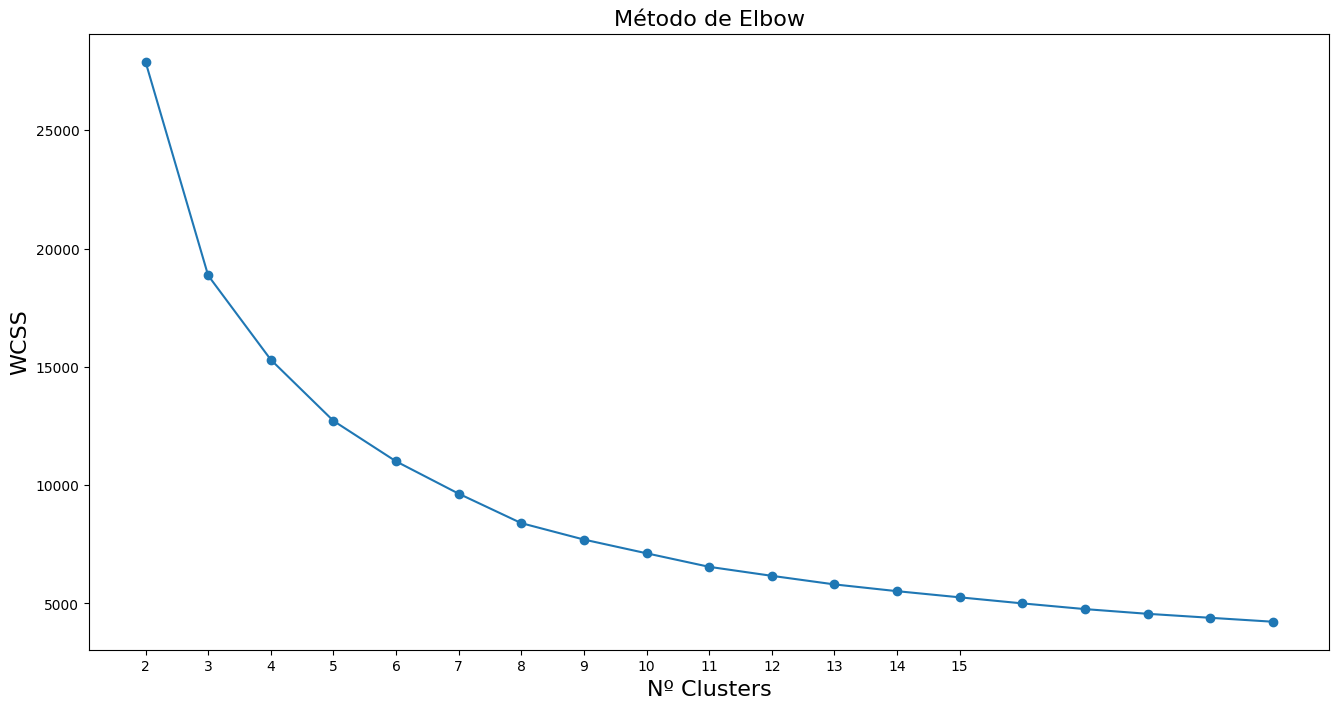

In [ ]:
## Metodo elbow
################################
#Identificando a quantidade de clusters - 
elbow = []
K = range(2,21)
for k in K:
    print(k)
    kmeanElbow = KMeans(n_clusters = k , init='k-means++',n_init=50, max_iter=150, random_state =100).fit(df_cluster_fit_standard)
    elbow.append(kmeanElbow.inertia_)
    
################################# nesse caso poderia ser 7 ou 8 pois apartir do 6 o erro quadrático médio se torna menor e menos significativo, mas pensando no contexto dos dados e que estamos falando em valores altos, pode-ser que uma pequena melhora do erro quadratico medio pode ser muito siginifcativo
plot.figure(figsize=(16,8))
plot.plot(K, elbow, marker='o')
plot.xlabel('Nº Clusters', fontsize=16)
plot.xticks(range(2,16)) # ajustar range
plot.ylabel('WCSS', fontsize=16) # Soma dos Quadrados Dentro dos Clusters
plot.title('Método de Elbow', fontsize=16)
plot.show()

In [ ]:
elbow

In [ ]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = fabs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(builtins.max(distances)) + 2

In [ ]:
# calculando a quantidade ótima de clusters
n = optimal_number_of_clusters(elbow)
print(n)

7


In [ ]:
#################################
# Método K means
kmeans = KMeans(n_clusters = 5,init='k-means++',n_init=50, max_iter=150, random_state =100).fit(df_cluster_fit_standard)

#################################
print(kmeans.labels_)
print(kmeans)

[3 3 4 ... 0 4 1]
KMeans(max_iter=150, n_clusters=5, n_init=50, random_state=100)


In [ ]:
# Salvando o modelo como um objeto pickle
#joblib.dump(kmeans, "kmeans_5.pkl")

## Análise dos grupos

In [14]:
# leitura do modelo como um objeto pickle
kmeans = joblib.load("kmeans_5.pkl")

In [15]:
#################################
## Rotualando os dados
labels = pd.DataFrame(data=kmeans.labels_)
#################################
df_cluster.loc[:, 'Cluster'] = kmeans.labels_

In [16]:
### Checando a quantidade por cluster
df_cluster.Cluster.value_counts(dropna=False)

Cluster
0    115617
3     99623
4     86500
1     85894
2     24307
Name: count, dtype: int64

In [17]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411941 entries, 0 to 411940
Data columns (total 39 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   CPF_CNPJ                              411941 non-null  float64
 1   FILIAL                                411941 non-null  object 
 2   SEXO                                  411941 non-null  object 
 3   IDADE                                 411941 non-null  int32  
 4   NATUREZA_OCUPACAO                     409068 non-null  object 
 5   ESTADO_CIVIL                          402532 non-null  object 
 6   CANAL_ORIGEM                          411941 non-null  object 
 7   GRAU_ESCOLARIDADE                     384159 non-null  object 
 8   UF_RESIDENCIA                         411941 non-null  object 
 9   NACIONALIDADE                         411914 non-null  object 
 10  TEMPO_RELACIONAMENTO_KREDILIG         411941 non-null  int32  
 11  

In [ ]:
#df_cluster_csv=df_cluster[["CPF_CNPJ","Cluster"]]
#df_cluster_csv.to_csv('cluster5.csv', index=False)

<Axes: >

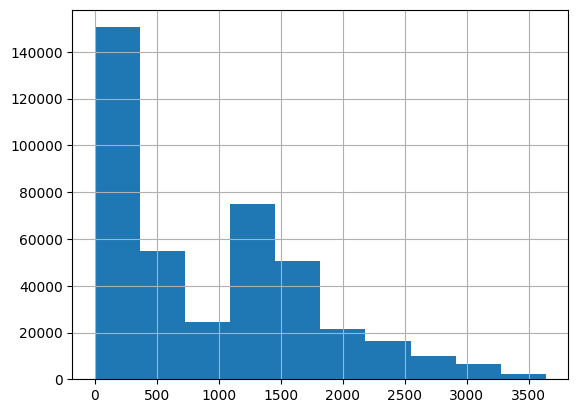

In [21]:
df_cluster["dias_ultimo_contrato"].hist()

In [23]:
df_cluster.dias_ultimo_contrato.describe()

count   411941.00
mean       937.72
std        810.83
min          0.00
25%        193.00
50%        734.00
75%       1481.00
max       3638.00
Name: dias_ultimo_contrato, dtype: float64

In [24]:
df_cluster.dias_ultimo_contrato.value_counts()

dias_ultimo_contrato
25      1497
23      1262
53      1132
152     1126
18      1114
        ... 
3088       1
2792       1
388        1
2392       1
1088       1
Name: count, Length: 3254, dtype: int64

In [26]:
pd.qcut(df_cluster.dias_ultimo_contrato,q=6).value_counts()

dias_ultimo_contrato
(-0.001, 117.0]     68997
(734.0, 1292.0]     68781
(1292.0, 1709.0]    68613
(1709.0, 3638.0]    68554
(117.0, 307.0]      68544
(307.0, 734.0]      68452
Name: count, dtype: int64

In [ ]:
# Categorizando as variáveis numéricas
df_cluster['faixa_Idade']=pd.qcut(df_cluster.IDADE,q=8)# categorização por quantil
df_cluster['faixa_Relacionamento']=pd.cut(df_cluster.TEMPO_RELACIONAMENTO_KREDILIG, 
                                          bins=[0,365,365*2,365*3,365*4,365*5,365*6,365*7,365*8, 365*9,np.inf], 
                                          labels=["Até 1 ano", "1 a 2 anos", "2 a 3 anos","3 a 4 anos","4 a 5 anos","5 a 6 anos","6 a 7 anos","7 a 8 anos","8 a 9 anos", "Acima de 9 anos"]) # categorização por bins já definidos
df_cluster['faixa_Inatividade']=pd.qcut(df_cluster.TEMPO_INATIVIDADE_KREDILIG,q=6)
df_cluster['faixa_Limite']=pd.cut(df_cluster.LIMITE_TOTAL,bins=[-0.99,0,1000,5000,10000,20000,np.inf],labels=["Sem Limite","Até R$1 mil","R$1 mil a R$5 mil","R$5 mil a R$10mil","R$10 mil a R$20mil","Acima de R$20mil"])
df_cluster['Qtd_contratos_aberto_atraso']=pd.cut(df_cluster.Qtd_contratos_aberto_atraso_total,bins=[-0.99,0,1,np.inf],labels=["0","1","+1"])
df_cluster['Qtd_contratos_aberto_regular']=pd.cut(df_cluster.Qtd_contratos_aberto_regular_total,bins=[-0.99,0,1,3,np.inf],labels=["0","1","3","+3"])
df_cluster['Qtd_contratos_fechado_atraso']=pd.cut(df_cluster.Qtd_contratos_fechado_atraso_total,bins=[-0.99,0,1,3,np.inf],labels=["0","1","3","+3"])
df_cluster['Qtd_contratos_fechado_regular']=pd.cut(df_cluster.Qtd_contratos_fechado_regular_total,bins=[-0.99,0,1,3,10,np.inf],labels=["0","1","1 a 3","4 a 10","+10"])
df_cluster['faixa_valor_da_parcela']=pd.cut(df_cluster.valor_da_parcela_aberto_total,bins=[-0.99,0,100,250,500,1000,np.inf],labels=["Sem contrato aberto","Até R$100","R$ 100 a R$250","R$251 a R$500", "R$501  a R$1 mil", "R$ Acima de R$1 mil"])
df_cluster['faixa_qtd_parcelas_pagas']=pd.cut(df_cluster.qtd_parcelas_pagas_total,bins=[-0.99,0,10,20,50,np.inf],labels=["0","Até 10","11 a 20","21 a 50", "Acima 50"])
df_cluster['faixa_qtd_parcelas_abertas']=pd.cut(df_cluster.qtd_parcelas_aberta_total,bins=[-0.99,0,10,20,50,np.inf],labels=["0","Até 10","11 a 20","21 a 50", "Acima 50"])
df_cluster['faixa_media_atraso']=pd.cut(df_cluster.media_atraso_dias,bins=[-0.99,0,1,2,3,7,15,30,60,np.inf],labels=["0","1","2","3","4 a 7","8 a 15","16 a 30","31 a 60","Acima 60"])
df_cluster['faixa_principal_total']=pd.cut(df_cluster.principal_total_total,bins=[-0.99,0,1000,2000,3000,5000,10000,np.inf],labels=["0","Até R$1 mil","R$1 mil a R$2 mil","R$2 mil a R$3mil","R$3 mil a R$4mil","R$5 mil a R$10mil","Acima de R$10mil"])
df_cluster['faixa_creditos_a_vencer']=pd.cut(df_cluster.creditos_a_vencer_total,bins=[-0.99,0,1000,2000,3000,5000,np.inf],labels=["0","Até R$1 mil","R$1 mil a R$2 mil","R$2 mil a R$3mil","R$3 mil a R$5mil","Acima de R$5mil"])
df_cluster['faixa_creditos_vencidos']=pd.cut(df_cluster.creditos_vencidos_total,bins=[-0.99,0,1000,np.inf],labels=["0","Até R$1 mil","Acima de R$1mil"])
df_cluster['faixa_media_entre_contratos']=pd.cut(df_cluster.media_dias_entre_contratos,bins=[-0.99,0,30,60,90,180,np.inf],labels=["0","Até 30","31 a 60","61 a 90","91 a 180","Acima de 180"])
df_cluster['med_entre_contratos_comb']=pd.cut(df_cluster.media_dias_entre_contratos_combinado,bins=[-0.99,0,30,60,90,180,365,np.inf],labels=["0","Até 30","31 a 60","61 a 90","91 a 180","180 a 365", "Acima de 1 ano"])
df_cluster['faixa_dias_ultimo_contrato']=pd.qcut(df_cluster.dias_ultimo_contrato,q=6)

df_cluster.head()


,CPF_CNPJ,SEXO,IDADE,NATUREZA_OCUPACAO,ESTADO_CIVIL,CANAL_ORIGEM,GRAU_ESCOLARIDADE,UF_RESIDENCIA,NACIONALIDADE,TEMPO_RELACIONAMENTO_KREDILIG,...,faixa_valor_da_parcela,faixa_qtd_parcelas_pagas,faixa_qtd_parcelas_abertas,faixa_media_atraso,faixa_principal_total,faixa_creditos_a_vencer,faixa_creditos_vencidos,faixa_media_entre_contratos,med_entre_contratos_comb,faixa_dias_ultimo_contrato
0,1148044.00,F,42,PROMOTOR DE VENDAS,DIVORCIADO,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,1384,...,Sem contrato aberto,21 a 50,0,3,R$3 mil a R$4mil,0,0,0,Acima de 1 ano,"(307.0, 734.0]"
1,2030098.00,F,41,PROFESSOR ENSINO MEDIO(2 GRAU),DIVORCIADO,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,441,...,Sem contrato aberto,Até 10,0,0,R$1 mil a R$2 mil,0,0,0,0,"(307.0, 734.0]"
2,3130096.00,F,43,AGENTE COMUNITARIO DE SAUDE,CASADO,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,1498,...,Sem contrato aberto,Acima 50,0,Acima 60,R$5 mil a R$10mil,0,0,0,0,"(734.0, 1292.0]"
3,3634990.00,M,46,MOTORISTA CAMINHAO,UNIAO ESTAVEL,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,3036,...,Sem contrato aberto,21 a 50,0,0,R$3 mil a R$4mil,0,0,Acima de 180,Acima de 1 ano,"(1709.0, 3638.0]"
4,3747921.00,F,55,PENSIONISTA,CASADO,Fisico,ENSINO MEDIO 2� GRAU INC,SC,BRASILEIRO,2233,...,Sem contrato aberto,21 a 50,0,8 a 15,R$1 mil a R$2 mil,0,0,0,0,"(1292.0, 1709.0]"


### EDA cluster

In [ ]:
#################################
# Estatísticas das variáveis numéricas
#################################
descritiva = df_cluster.groupby('Cluster').agg({
    "IDADE":['min','mean', 'median','max', 'std'],
    #"RENDA_DIGITADA":['min','mean', 'median','max', 'std'],
    "TEMPO_RELACIONAMENTO_KREDILIG":['min','mean', 'median','max', 'std'],
    "TEMPO_INATIVIDADE_KREDILIG":['min','mean', 'median','max', 'std'],
    #"SCORE":['min','mean', 'median','max', 'std'],
    "LIMITE_TOTAL":['min','mean', 'median','max', 'std'],
    "LIMITE_A_VISTA":['min','mean', 'median','max', 'std'],
    "LIMITE_SAQUE":['min','mean', 'median','max', 'std'],
    "LIMITE_MENSAL":['min','mean', 'median','max', 'std'],
    #"qtd_contratos_reneg_total":['min','mean', 'median','max', 'std'],
    "Qtd_contratos_aberto_atraso_total":['min','mean', 'median','max', 'std'],
    "Qtd_contratos_aberto_regular_total":['min','mean', 'median','max', 'std'],
    "Qtd_contratos_fechado_atraso_total":['min','mean', 'median','max', 'std'],
    "Qtd_contratos_fechado_regular_total":['min','mean', 'median','max', 'std'],
    "valor_da_parcela_aberto_total":['min','mean', 'median','max', 'std'],
    #"Renda_comprometida":['min','mean', 'median','max', 'std'],
    "qtd_parcelas_pagas_total":['min','mean', 'median','max', 'std'],
    "qtd_parcelas_aberta_total":['min','mean', 'median','max', 'std'],
    "media_atraso_dias":['min','mean', 'median','max', 'std'],
    "principal_total_total":['min','mean', 'median','max', 'std'],
    "creditos_a_vencer_total":['min','mean', 'median','max', 'std'],
    "creditos_vencidos_total":['min','mean', 'median','max', 'std'],
    "media_dias_entre_contratos" :['min','mean', 'median','max', 'std'],
    "media_dias_entre_contratos_combinado" :['min','mean', 'median','max', 'std'],
    "dias_ultimo_contrato" :['min','mean', 'median','max', 'std', 'count']
    #"Qtd_produtos" :['min','mean', 'median','max', 'std','count']
})
descritiva.to_excel("descritiva_cluster5.xlsx")
#################################

In [28]:
df_cluster.columns.to_list()

['CPF_CNPJ',
 'SEXO',
 'IDADE',
 'NATUREZA_OCUPACAO',
 'ESTADO_CIVIL',
 'CANAL_ORIGEM',
 'GRAU_ESCOLARIDADE',
 'UF_RESIDENCIA',
 'NACIONALIDADE',
 'TEMPO_RELACIONAMENTO_KREDILIG',
 'TEMPO_INATIVIDADE_KREDILIG',
 'SITUACAO_CONTA',
 'MOTIVO_SITUACAO_CONTA',
 'SITUACAO_FATURA',
 'LIMITE_TOTAL',
 'LIMITE_A_VISTA',
 'LIMITE_SAQUE',
 'LIMITE_MENSAL',
 'CDC',
 'CP',
 'CREDIARIO',
 'CARTAO',
 'Qtd_contratos_aberto_atraso_total',
 'Qtd_contratos_aberto_regular_total',
 'Qtd_contratos_fechado_atraso_total',
 'Qtd_contratos_fechado_regular_total',
 'valor_da_parcela_aberto_total',
 'qtd_parcelas_pagas_total',
 'qtd_parcelas_aberta_total',
 'media_atraso_dias',
 'principal_total_total',
 'creditos_a_vencer_total',
 'creditos_vencidos_total',
 'media_dias_entre_contratos',
 'media_dias_entre_contratos_combinado',
 'dias_ultimo_contrato',
 'Inad_e_reneg',
 'Cluster',
 'faixa_Idade',
 'faixa_Relacionamento',
 'faixa_Inatividade',
 'faixa_Limite',
 'Qtd_contratos_aberto_atraso',
 'Qtd_contratos_aberto

In [29]:
tabelas_de_contingencia = {}

variavel_alvo = 'Cluster'

# Selecionando apenas colunas categóricas
colunas_categoricas = [
 'NATUREZA_OCUPACAO',
 'SEXO',
 'ESTADO_CIVIL',
 'CANAL_ORIGEM',
 'GRAU_ESCOLARIDADE',
 'UF_RESIDENCIA',
 'NACIONALIDADE',
 'SITUACAO_CONTA',
 'MOTIVO_SITUACAO_CONTA',
 'SITUACAO_FATURA',
 'CANAL_ORIGEM',
 'CDC',
 'CP',
 'CREDIARIO',
 'CARTAO',
 'Inad_e_reneg',
 'Qtd_contratos_aberto_atraso',
 'Qtd_contratos_aberto_regular',
 'Qtd_contratos_fechado_atraso',
 'Qtd_contratos_fechado_regular',
 'faixa_Idade',
 'faixa_Relacionamento',
 'faixa_Inatividade',
 'faixa_Limite',
 'faixa_valor_da_parcela',
 'faixa_qtd_parcelas_pagas',
 'faixa_qtd_parcelas_abertas',
 'faixa_media_atraso',
 'faixa_principal_total',
 'faixa_creditos_a_vencer',
 'faixa_creditos_vencidos',
 'faixa_media_entre_contratos',
 'med_entre_contratos_comb',
 "faixa_dias_ultimo_contrato"]

# Criando tabelas de contingência para cada variável categórica
for col in colunas_categoricas:
    print(f"\nTabela de Contingência: {col} x {variavel_alvo}")
    tabela =pd.crosstab(df_cluster[col], df_cluster[variavel_alvo])
    tabelas_de_contingencia[col]=tabela
    print(tabela)

'''#Criando um nome de arquivo com data
nome_arquivo = f"tabelas_cluster5.xlsx"

# Salvando no Excel
with pd.ExcelWriter(nome_arquivo, engine="xlsxwriter") as writer:
    for col, tabela in tabelas_de_contingencia.items():
        tabela.to_excel(writer, sheet_name=col)'''


Tabela de Contingência: NATUREZA_OCUPACAO x Cluster
Cluster                  0    1    2    3    4
NATUREZA_OCUPACAO                             
ABATEDOR                24   17    3   20   15
ACOUGUEIRO             277  190   67  275  208
ACROBATA                 0    1    1    1    0
ACUPUNTURISTA            3    3    0    0    3
ADESTRADOR DE ANIMAIS    5    7    3   10    8
...                    ...  ...  ...  ...  ...
VISUAL MERCHANDISER      7    6    1    4    4
VIVEIRISTA FLORESTAL     6    4    0    6    4
WEB DESIGNER             3    3    0    2    1
ZELADOR                908  657  157  768  615
ZOOTECNISTA              0    0    1    0    1

[830 rows x 5 columns]

Tabela de Contingência: SEXO x Cluster
Cluster      0      1      2      3      4
SEXO                                      
            34     33     12     36     33
F        61845  45499  12658  52767  46413
M        53738  40362  11637  46820  40054

Tabela de Contingência: ESTADO_CIVIL x Cluster
Cluster  

'#Criando um nome de arquivo com data\nnome_arquivo = f"tabelas_cluster5.xlsx"\n\n# Salvando no Excel\nwith pd.ExcelWriter(nome_arquivo, engine="xlsxwriter") as writer:\n    for col, tabela in tabelas_de_contingencia.items():\n        tabela.to_excel(writer, sheet_name=col)'

### Spark

In [ ]:
df_cluster_csv=spark.read.csv("C:/Users/fernando.monteiro/deep-torch-example/KAB/Behavior_KAB/Cluster/cluster5.csv",header=True,inferSchema=True, sep=",")

df_clientes_historico = (
        df_clientes_historico
        .join(df_cluster_csv, on="cpf_cnpj", how="left")
    )
df_clientes_historico.printSchema()

root
 |-- CPF_CNPJ: double (nullable = false)
 |-- ANO_MES_MOVIMENTO: timestamp (nullable = true)
 |-- DATA_MOVIMENTO: date (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- IDADE: integer (nullable = true)
 |-- ESTADO_CIVIL: string (nullable = true)
 |-- GRAU_ESCOLARIDADE: string (nullable = true)
 |-- NATUREZA_OCUPACAO: string (nullable = true)
 |-- RENDA_DIGITADA: double (nullable = false)
 |-- RENDA_VALIDA: double (nullable = false)
 |-- NACIONALIDADE: string (nullable = true)
 |-- UF_NASCIMENTO: string (nullable = true)
 |-- CIDADE_NASCIMENTO: string (nullable = true)
 |-- UF_RESIDENCIA: string (nullable = true)
 |-- CIDADE_RESIDENCIA: string (nullable = true)
 |-- FILIAL: string (nullable = true)
 |-- TEMPO_RELACIONAMENTO_KREDILIG: integer (nullable = true)
 |-- TEMPO_INATIVIDADE_KREDILIG: integer (nullable = true)
 |-- BLACKLIST: string (nullable = true)
 |-- DATA_ABERTURA_CONTA: date (nullable = true)
 |-- SITUACAO_CONTA: string (nullable = true)
 |-- MOTIVO_SITUACAO_C

In [ ]:
tabela_cruzada = df_clientes_historico.crosstab("MOTIVO_SITUACAO_CONTA", "Cluster")
tabela_cruzada.show()


+-----------------------------+-----+-----+----+-----+-----+
|MOTIVO_SITUACAO_CONTA_Cluster|    0|    1|   2|    3|    4|
+-----------------------------+-----+-----+----+-----+-----+
|                  INATIVIDADE|   42|55709|5287|    0|29948|
|                   REATIVACAO|    0|    1|   0|    1|    0|
|                     ATRASO B|  151|25966|9605|    6|46556|
|                    CANCELADO|    9| 1805| 739|    0| 2029|
|                        PAGTO|21653|  259| 367|17242| 1872|
|           LIBERA/BLOQ CARTAO|  380|  225|5771|   14| 1133|
|                  DESBLOQUEIO|   62|    0|   2|   42|   13|
|                       ATRASO| 4336|   57|  16| 3299|  349|
|              CANCELADOATRASO|    0|  614|   4|    0|   40|
|                         null|88984| 1258|2516|79019| 4560|
+-----------------------------+-----+-----+----+-----+-----+



## Teste

### Pré-Processamento

In [ ]:
# filtro Filial = 18
#df_filial18=df_cluster[df_cluster['FILIAL']=="18"]
#df_filial18.to_csv('filial18.csv', index=False)
#df_filial18=pd.read_csv("C:/Users/fernando.monteiro/deep-torch-example/KAB/Behavior_KAB/filial18.csv", sep=",", header=0, index_col=None)
#df_filial18.head()

,CPF_CNPJ,FILIAL,SEXO,IDADE,NATUREZA_OCUPACAO,ESTADO_CIVIL,CANAL_ORIGEM,GRAU_ESCOLARIDADE,UF_RESIDENCIA,NACIONALIDADE,...,qtd_parcelas_aberta_total,media_atraso_dias,principal_total_total,creditos_a_vencer_total,creditos_vencidos_total,media_dias_entre_contratos,media_dias_entre_contratos_combinado,dias_ultimo_contrato,Inad_e_reneg,Cluster
0,3806952.00,18,F,47,FAXINEIRO,UNIAO ESTAVEL,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,...,28,4.00,20387.94,3991.88,0.00,269.73,154.27,5,NAO,0
1,4168941.00,18,F,65,EMPREGADO DOMESTICO DIARISTA,SOLTEIRO,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,...,0,2.50,1355.44,0.00,0.00,0.00,0.00,515,NAO,3
2,4216938.00,18,F,50,AUXILIAR DE SAUDE,CASADO,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,...,0,4.83,2658.91,0.00,0.00,196.25,392.50,116,NAO,3
3,4522974.00,18,F,59,RECEPCIONISTA. EM GERAL,CASADO,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,...,0,2.00,869.84,0.00,0.00,0.00,0.00,1688,NAO,1
4,6441963.00,18,F,71,COORDENADOR PEDAGOGICO,DIVORCIADO,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,...,46,6.67,47847.26,20701.61,3204.64,61.92,123.83,130,SIM,0


In [197]:
## Select Colunas
#df_cluster.columns.to_list()
df_fit=df_filial18[[
 'SEXO',
 'IDADE',
 'ESTADO_CIVIL',
 'CANAL_ORIGEM',
 'GRAU_ESCOLARIDADE',
 'NACIONALIDADE',
 'TEMPO_RELACIONAMENTO_KREDILIG',
 'TEMPO_INATIVIDADE_KREDILIG',
 'LIMITE_TOTAL',
 'LIMITE_A_VISTA',
 'LIMITE_SAQUE',
 'LIMITE_MENSAL',
 'CDC',
 'CP',
 'CREDIARIO',
 'CARTAO',
 'Qtd_contratos_aberto_atraso_total',
 'Qtd_contratos_aberto_regular_total',
 'Qtd_contratos_fechado_atraso_total',
 'Qtd_contratos_fechado_regular_total',
 'valor_da_parcela_aberto_total',
 'qtd_parcelas_pagas_total',
 'qtd_parcelas_aberta_total',
 'media_atraso_dias',
 'principal_total_total',
 'creditos_a_vencer_total',
 'creditos_vencidos_total',
 'media_dias_entre_contratos',
 'media_dias_entre_contratos_combinado',
 'dias_ultimo_contrato',
 'Inad_e_reneg',
 'Cluster']]

In [198]:
df_fit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9537 entries, 5 to 411940
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SEXO                                  9537 non-null   object 
 1   IDADE                                 9537 non-null   int32  
 2   ESTADO_CIVIL                          9428 non-null   object 
 3   CANAL_ORIGEM                          9537 non-null   object 
 4   GRAU_ESCOLARIDADE                     8650 non-null   object 
 5   NACIONALIDADE                         9537 non-null   object 
 6   TEMPO_RELACIONAMENTO_KREDILIG         9537 non-null   int32  
 7   TEMPO_INATIVIDADE_KREDILIG            9537 non-null   int32  
 8   LIMITE_TOTAL                          9537 non-null   float64
 9   LIMITE_A_VISTA                        9537 non-null   float64
 10  LIMITE_SAQUE                          9537 non-null   float64
 11  LIMITE_MENSAL       

In [199]:
# Porcentagem de valores faltantes
print(((df_fit.isnull().sum() / df_fit.shape[0]) * 100).sort_values(ascending=False))

GRAU_ESCOLARIDADE                      9.30
ESTADO_CIVIL                           1.14
IDADE                                  0.00
SEXO                                   0.00
CANAL_ORIGEM                           0.00
NACIONALIDADE                          0.00
TEMPO_RELACIONAMENTO_KREDILIG          0.00
TEMPO_INATIVIDADE_KREDILIG             0.00
LIMITE_TOTAL                           0.00
LIMITE_A_VISTA                         0.00
LIMITE_SAQUE                           0.00
LIMITE_MENSAL                          0.00
CDC                                    0.00
CP                                     0.00
CREDIARIO                              0.00
CARTAO                                 0.00
Qtd_contratos_aberto_atraso_total      0.00
Qtd_contratos_aberto_regular_total     0.00
Qtd_contratos_fechado_atraso_total     0.00
Qtd_contratos_fechado_regular_total    0.00
valor_da_parcela_aberto_total          0.00
qtd_parcelas_pagas_total               0.00
qtd_parcelas_aberta_total       

In [200]:
print((df_fit.isnull().sum()).sort_values(ascending=False))

GRAU_ESCOLARIDADE                       887
ESTADO_CIVIL                            109
IDADE                                     0
SEXO                                      0
CANAL_ORIGEM                              0
NACIONALIDADE                             0
TEMPO_RELACIONAMENTO_KREDILIG             0
TEMPO_INATIVIDADE_KREDILIG                0
LIMITE_TOTAL                              0
LIMITE_A_VISTA                            0
LIMITE_SAQUE                              0
LIMITE_MENSAL                             0
CDC                                       0
CP                                        0
CREDIARIO                                 0
CARTAO                                    0
Qtd_contratos_aberto_atraso_total         0
Qtd_contratos_aberto_regular_total        0
Qtd_contratos_fechado_atraso_total        0
Qtd_contratos_fechado_regular_total       0
valor_da_parcela_aberto_total             0
qtd_parcelas_pagas_total                  0
qtd_parcelas_aberta_total       

In [201]:
# variável target em numérica
df_fit['Inad_e_reneg'] = df_fit['Inad_e_reneg'].map({'SIM': 1, 'NAO': 0})

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_7856\4151367886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit['Inad_e_reneg'] = df_fit['Inad_e_reneg'].map({'SIM': 1, 'NAO': 0})


In [202]:
df_fit.Inad_e_reneg.value_counts()
df_fit["Cluster"]=df_fit["Cluster"].astype("str")
df_fit.Cluster.value_counts()

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_7856\3737083720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit["Cluster"]=df_fit["Cluster"].astype("str")


Cluster
0    2624
4    2203
1    2127
3    2033
2     550
Name: count, dtype: int64

In [203]:
# Separação em teste e treino

#Variável de interesse
outcome = df_fit >> select(X.Inad_e_reneg)

# Remover a variável resposta do conjunto de dados
df_fit.drop(['Inad_e_reneg'],axis=1, inplace=True)

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_7856\2121485172.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit.drop(['Inad_e_reneg'],axis=1, inplace=True)


In [204]:
# amostragem

## Definindo treino e teste
X_train, X_test, y_train, y_test=train_test_split(df_fit,outcome, test_size=0.3, random_state=2025)

In [ ]:
X_train.shape #qtd treino

(6675, 31)

In [206]:
X_test.shape #qtd teste

(2862, 31)

In [ ]:
## imputação

# imputação KNN - variáveis categoricas

'''df_cluster_imput=df_cluster_fit.copy()
df_encoded = df_cluster_imput.copy()

# Variáveis categoricas
col_categoricas = ['SEXO','CANAL_ORIGEM','UF_RESIDENCIA','SITUACAO_CONTA','SITUACAO_FATURA','Inad_e_reneg']
# Variaveis para inputação
cols_com_nulos = ["ESTADO_CIVIL","GRAU_ESCOLARIDADE","NACIONALIDADE"]

encoders = {}

for col in col_categoricas:
    enc = OrdinalEncoder()
    df_encoded[col] = enc.fit_transform(df_encoded[[col]].astype(str))
    encoders[col] = enc 


for col in cols_com_nulos:
    col_temp = df_encoded[col].astype(str)
    mask_valid = col_temp != 'None'
    enc = OrdinalEncoder()
    df_encoded.loc[mask_valid, col] = enc.fit_transform(col_temp[mask_valid].values.reshape(-1, 1))
    encoders[col] = enc

## Inputação atraves do metodo KNN (K vizinhos mais próximos)
id = df_encoded['CPF_CNPJ'].copy()  
df_encoded = df_encoded.drop(columns=['CPF_CNPJ'])

# Padronização
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)

## KNN inputação
KNN_inputer=KNNImputer()
df_KNN_imputed = pd.DataFrame(KNN_inputer.fit_transform(df_scaled), columns=df_scaled.columns)

# Reverte padronização
df_imputed = pd.DataFrame(scaler.inverse_transform(df_KNN_imputed), columns=df_scaled.columns)

## Voltando as variáveis originais com os dados imputados
for col_name in encoders:
    reformatado = df_imputed[col_name].values.reshape(-1,1)
    df_imputed[col_name] = encoders[col_name].inverse_transform(reformatado)


df_imputed['CPF_CNPJ'] = id.values'''

## Imputação simples
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer(strategy='mean')

var_null_cat=["GRAU_ESCOLARIDADE","ESTADO_CIVIL"]
#var_null_num=["TEMPO_RELACIONAMENTO_KREDILIG"]

X_train[var_null_cat] = X_train[var_null_cat].replace({None: np.nan})
#X_train[var_null_num] = X_train[var_null_num].replace({None: np.nan})


X_train[var_null_cat] = pd.DataFrame(
    imputer_cat.fit_transform(X_train[var_null_cat]),
    columns=var_null_cat,
    index=X_train.index
)
'''X_train[var_null_num] = pd.DataFrame(
    imputer_num.fit_transform(X_train[var_null_num]),
    columns=var_null_num,
    index=X_train.index
)'''

'X_train[var_null_num] = pd.DataFrame(\n    imputer_num.fit_transform(X_train[var_null_num]),\n    columns=var_null_num,\n    index=X_train.index\n)'

In [208]:
## conjunto de teste - precisa ser o modelo que treinado para evitar vazamento de informação

X_test[var_null_cat] = X_test[var_null_cat].replace({None: np.nan})
#X_test[var_null_num] = X_test[var_null_num].replace({None: np.nan})


X_test[var_null_cat] = pd.DataFrame(
    imputer_cat.transform(X_test[var_null_cat]),
    columns=var_null_cat,
    index=X_test.index
)

'''X_test[var_null_num] = pd.DataFrame(
    imputer_cat.transform(X_test[var_null_num]),
    columns=var_null_num,
    index=X_test.index
)'''

'X_test[var_null_num] = pd.DataFrame(\n    imputer_cat.transform(X_test[var_null_num]),\n    columns=var_null_num,\n    index=X_test.index\n)'

In [209]:
print((X_test.isnull().sum()).sort_values(ascending=False))
X_test.GRAU_ESCOLARIDADE.value_counts(dropna=False)
#X_train["GRAU_ESCOLARIDADE"].mode()

SEXO                                    0
IDADE                                   0
ESTADO_CIVIL                            0
CANAL_ORIGEM                            0
GRAU_ESCOLARIDADE                       0
NACIONALIDADE                           0
TEMPO_RELACIONAMENTO_KREDILIG           0
TEMPO_INATIVIDADE_KREDILIG              0
LIMITE_TOTAL                            0
LIMITE_A_VISTA                          0
LIMITE_SAQUE                            0
LIMITE_MENSAL                           0
CDC                                     0
CP                                      0
CREDIARIO                               0
CARTAO                                  0
Qtd_contratos_aberto_atraso_total       0
Qtd_contratos_aberto_regular_total      0
Qtd_contratos_fechado_atraso_total      0
Qtd_contratos_fechado_regular_total     0
valor_da_parcela_aberto_total           0
qtd_parcelas_pagas_total                0
qtd_parcelas_aberta_total               0
media_atraso_dias                 

GRAU_ESCOLARIDADE
ENSINO MEDIO 2� GRAU COM          2154
SUPERIOR COMPLETO                  222
ENSINO FUNDAMENTA 1� GRAU COMP     170
ENSINO FUNDAMENTAL 1� GRAU INC     146
ENSINO MEDIO 2� GRAU INC           111
SUPERIOR INCOMPLETO                 48
CURSO TECNICO                       10
SEM INSTRUCAO                        1
Name: count, dtype: int64

In [210]:
# one hot encoding 

'''# Cria o codificador
codificador = LabelEncoder()

# Converte colunas de texto em números
for coluna in df_cluster.columns:
    if df_cluster[coluna].dtype == "object":
        df_cluster[coluna] = df_cluster[coluna].astype(str)
        df_cluster[coluna] = codificador.fit_transform(df_cluster[coluna])
        
# Verifica as alterações
print(X_train_d.info())'''


X_train_d=pd.get_dummies(X_train, drop_first=True).astype(int)
X_train_d

,IDADE,TEMPO_RELACIONAMENTO_KREDILIG,TEMPO_INATIVIDADE_KREDILIG,LIMITE_TOTAL,LIMITE_A_VISTA,LIMITE_SAQUE,LIMITE_MENSAL,CDC,CP,CREDIARIO,...,GRAU_ESCOLARIDADE_ENSINO MEDIO 2� GRAU COM,GRAU_ESCOLARIDADE_ENSINO MEDIO 2� GRAU INC,GRAU_ESCOLARIDADE_SEM INSTRUCAO,GRAU_ESCOLARIDADE_SUPERIOR COMPLETO,GRAU_ESCOLARIDADE_SUPERIOR INCOMPLETO,NACIONALIDADE_ESTRANGEIRO,Cluster_1,Cluster_2,Cluster_3,Cluster_4
228028,67,2014,1681,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
127034,71,548,12,12000,2160,4800,1026,0,1,0,...,1,0,0,0,0,0,0,0,1,0
191504,26,33,12,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
334758,84,1269,21,23400,4212,9360,1170,0,0,1,...,1,0,0,0,0,0,0,0,0,0
332755,81,2179,1876,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255350,47,3281,300,6900,1242,2415,552,0,0,0,...,1,0,0,0,0,0,0,0,1,0
183886,63,1187,18,9274,1669,3246,742,1,1,1,...,1,0,0,0,0,0,0,0,1,0
232816,62,1049,19,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
13081,40,3078,153,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1


In [211]:
# Conjunto de teste
X_test_d = pd.get_dummies(X_test, drop_first=True).astype(int)
X_test_d = X_test_d.reindex(columns=X_train_d.columns, fill_value=0)

In [212]:
X_train_d.columns.to_list()

['IDADE',
 'TEMPO_RELACIONAMENTO_KREDILIG',
 'TEMPO_INATIVIDADE_KREDILIG',
 'LIMITE_TOTAL',
 'LIMITE_A_VISTA',
 'LIMITE_SAQUE',
 'LIMITE_MENSAL',
 'CDC',
 'CP',
 'CREDIARIO',
 'CARTAO',
 'Qtd_contratos_aberto_atraso_total',
 'Qtd_contratos_aberto_regular_total',
 'Qtd_contratos_fechado_atraso_total',
 'Qtd_contratos_fechado_regular_total',
 'valor_da_parcela_aberto_total',
 'qtd_parcelas_pagas_total',
 'qtd_parcelas_aberta_total',
 'media_atraso_dias',
 'principal_total_total',
 'creditos_a_vencer_total',
 'creditos_vencidos_total',
 'media_dias_entre_contratos',
 'media_dias_entre_contratos_combinado',
 'dias_ultimo_contrato',
 'SEXO_M',
 'ESTADO_CIVIL_DIVORCIADO',
 'ESTADO_CIVIL_SOLTEIRO',
 'ESTADO_CIVIL_UNIAO ESTAVEL',
 'ESTADO_CIVIL_VIUVO',
 'CANAL_ORIGEM_Fisico',
 'GRAU_ESCOLARIDADE_ENSINO FUNDAMENTA 1� GRAU COMP',
 'GRAU_ESCOLARIDADE_ENSINO FUNDAMENTAL 1� GRAU INC',
 'GRAU_ESCOLARIDADE_ENSINO MEDIO 2� GRAU COM',
 'GRAU_ESCOLARIDADE_ENSINO MEDIO 2� GRAU INC',
 'GRAU_ESCOLARIDADE_S

In [ ]:
# importancia, VIF, assimetria, seleção de variáveis, correlação
X_train_d_select=X_train_d[[
 'IDADE',
 'TEMPO_RELACIONAMENTO_KREDILIG',
 'TEMPO_INATIVIDADE_KREDILIG',
 'LIMITE_TOTAL',
 'CDC',
 'CP',
 'CREDIARIO',
 'CARTAO',
 'Qtd_contratos_fechado_regular_total',
 'media_atraso_dias',
 'creditos_a_vencer_total',
 'creditos_vencidos_total',
 'media_dias_entre_contratos_combinado',
 'Cluster_1',
 'Cluster_2',
 'Cluster_3',
 'Cluster_4',
 'SEXO_M',
 'ESTADO_CIVIL_DIVORCIADO',
 'ESTADO_CIVIL_SOLTEIRO',
 'ESTADO_CIVIL_UNIAO ESTAVEL',
 'ESTADO_CIVIL_VIUVO',
 'GRAU_ESCOLARIDADE_ENSINO FUNDAMENTA 1� GRAU COMP',
 'GRAU_ESCOLARIDADE_ENSINO FUNDAMENTAL 1� GRAU INC',
 'GRAU_ESCOLARIDADE_ENSINO MEDIO 2� GRAU INC',
 'GRAU_ESCOLARIDADE_SEM INSTRUCAO',
 'GRAU_ESCOLARIDADE_SUPERIOR COMPLETO',
 'GRAU_ESCOLARIDADE_SUPERIOR INCOMPLETO',
 'NACIONALIDADE_ESTRANGEIRO']] # talvez somar as var de limites

X_test_d_select = X_test_d.reindex(columns=X_train_d_select.columns, fill_value=0)


In [ ]:
# VIF, correlação, assimetria

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_d_select.columns
  
vif_data["VIF"] = [variance_inflation_factor(X_train_d_select.values, i)
                          for i in range(len(X_train_d_select.columns))]
print(vif_data.sort_values(by=['VIF'], ascending=False))

                                             Feature   VIF
1                      TEMPO_RELACIONAMENTO_KREDILIG 11.74
0                                              IDADE 10.59
7                                             CARTAO  4.98
3                                       LIMITE_TOTAL  3.84
2                         TEMPO_INATIVIDADE_KREDILIG  2.75
6                                          CREDIARIO  2.70
8                Qtd_contratos_fechado_regular_total  2.61
13                                         Cluster_1  2.30
10                           creditos_a_vencer_total  2.14
16                                         Cluster_4  2.08
12              media_dias_entre_contratos_combinado  1.99
5                                                 CP  1.91
15                                         Cluster_3  1.87
4                                                CDC  1.69
17                                            SEXO_M  1.63
19                             ESTADO_CIVIL_SOLTEIRO  1.

<function matplotlib.pyplot.show(close=None, block=None)>

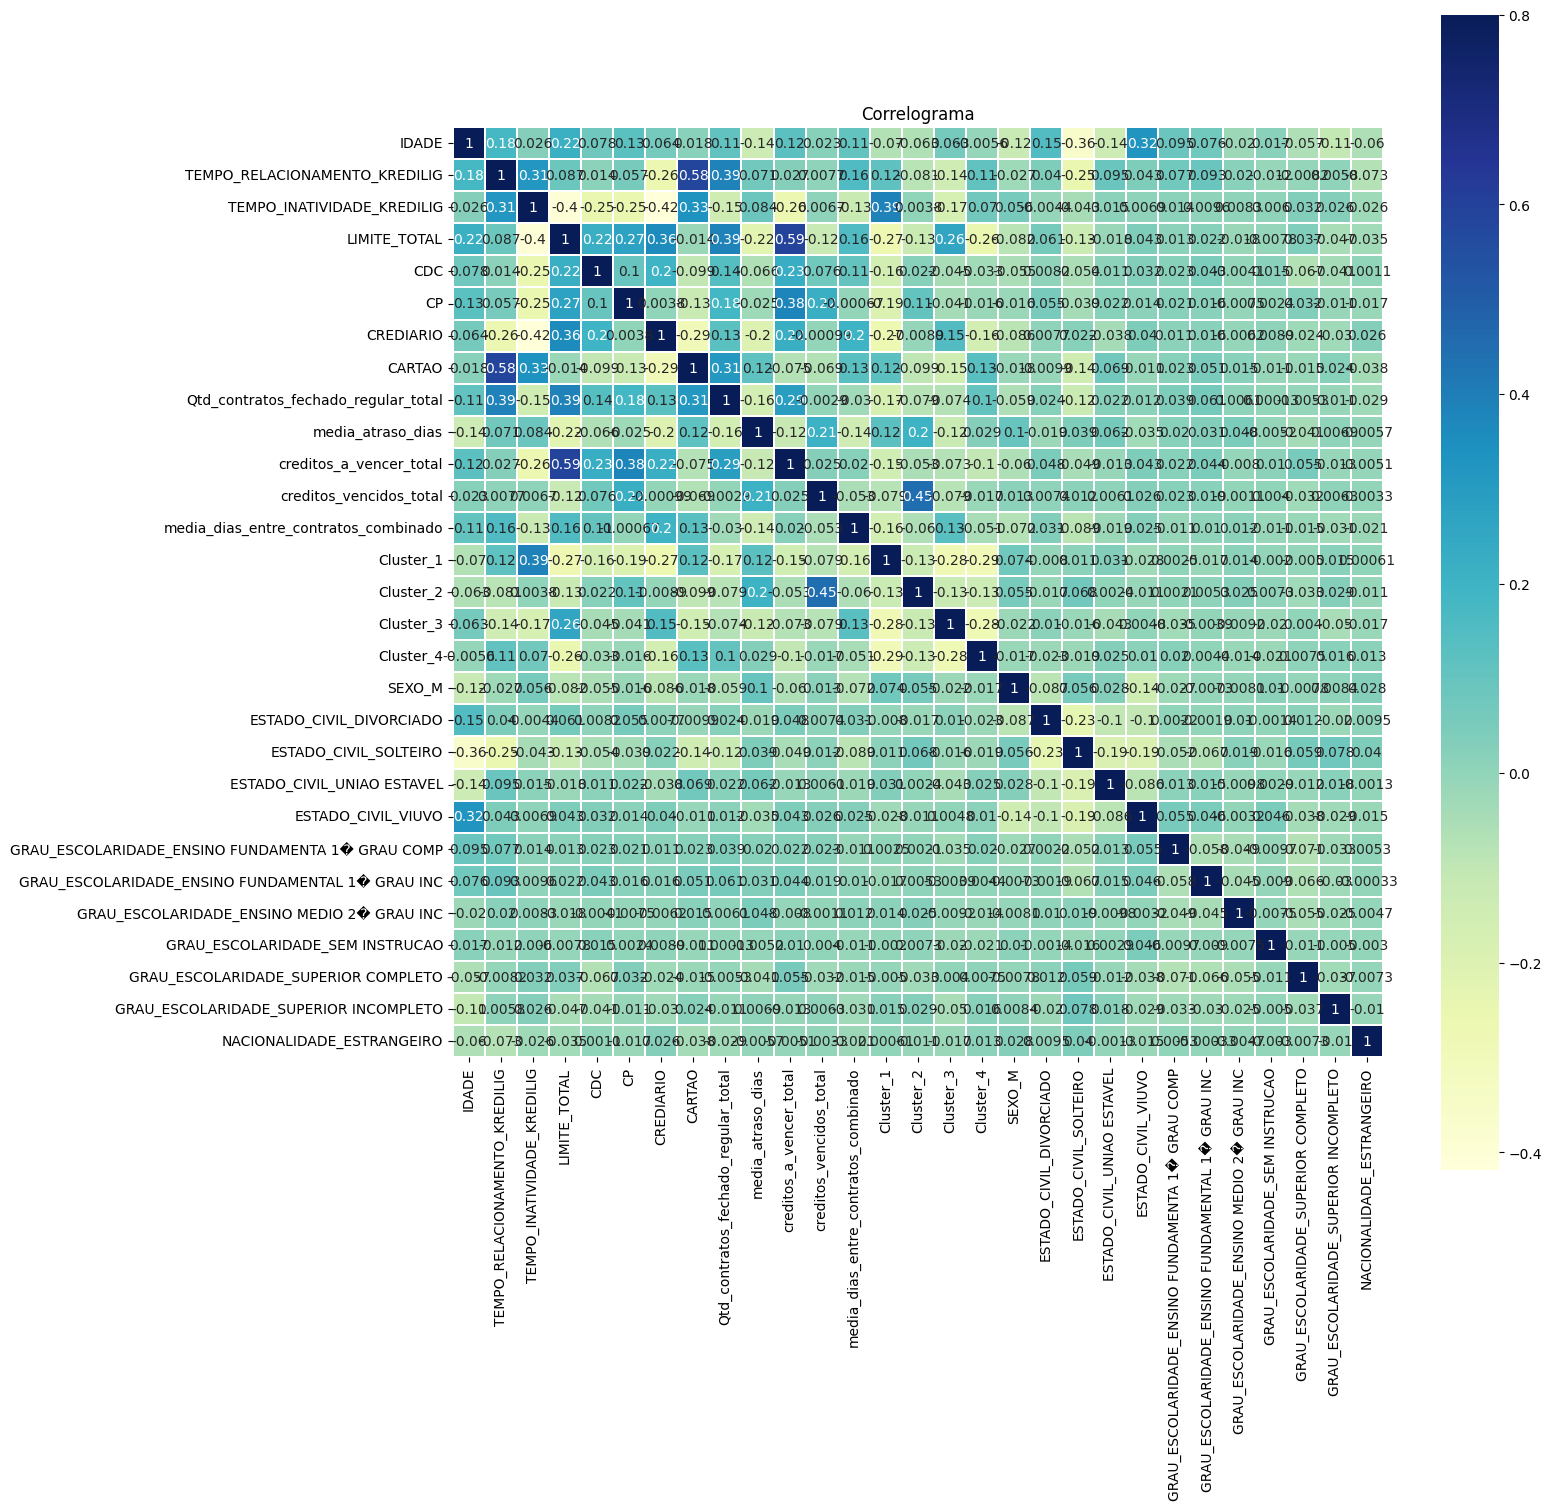

In [215]:
# Correlação
# Pearson
corr=X_train_d_select.corr(method='pearson')
plot.figure(figsize=(15,15))
sns.heatmap(corr,vmax=0.8,linewidths=0.01,
           square=True, annot=True,cmap='YlGnBu', linecolor='white')
plot.title('Correlograma')
plot.show

In [216]:
# Assimetria
skewed_feats=X_train_d_select.apply(lambda x: skew(x.dropna()))
print(skewed_feats.sort_values(ascending=False))

GRAU_ESCOLARIDADE_SEM INSTRUCAO                    25.78
NACIONALIDADE_ESTRANGEIRO                          12.80
creditos_vencidos_total                             7.75
GRAU_ESCOLARIDADE_SUPERIOR INCOMPLETO               7.56
Qtd_contratos_fechado_regular_total                 5.63
GRAU_ESCOLARIDADE_ENSINO MEDIO 2� GRAU INC          4.95
creditos_a_vencer_total                             4.94
GRAU_ESCOLARIDADE_ENSINO FUNDAMENTAL 1� GRAU INC    4.08
media_atraso_dias                                   3.92
Cluster_2                                           3.84
GRAU_ESCOLARIDADE_ENSINO FUNDAMENTA 1� GRAU COMP    3.74
GRAU_ESCOLARIDADE_SUPERIOR COMPLETO                 3.23
ESTADO_CIVIL_VIUVO                                  3.13
ESTADO_CIVIL_UNIAO ESTAVEL                          3.11
media_dias_entre_contratos_combinado                3.03
ESTADO_CIVIL_DIVORCIADO                             2.47
LIMITE_TOTAL                                        2.18
TEMPO_INATIVIDADE_KREDILIG     

In [217]:
# Variancia Nula
constant_features=[feat for feat in X_train_d_select.columns if X_train_d_select[feat].std()==0]
constant_features

[]

In [218]:
#normalização
# Padronização dos dados de treino
num_cols = ['IDADE',
 'TEMPO_RELACIONAMENTO_KREDILIG',
 'TEMPO_INATIVIDADE_KREDILIG',
 'LIMITE_TOTAL',
 'Qtd_contratos_fechado_regular_total',
 'media_atraso_dias',
 'creditos_a_vencer_total',
 'creditos_vencidos_total',
 'media_dias_entre_contratos_combinado']

# Inicializa o scaler
scaler = StandardScaler()

# Ajusta e transforma os dados de treino
X_train_d_select[num_cols] = pd.DataFrame(
    scaler.fit_transform(X_train_d_select[num_cols]),
    columns=num_cols,
    index=X_train_d_select.index
)
## Valores da padronização são obtidos em relação ao dados de treino

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_7856\2616402836.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_d_select[num_cols] = pd.DataFrame(


In [219]:
## conjunto de teste - precisa ser o modelo que treinado para evitar vazamento de informação
X_test_d_select[num_cols] = pd.DataFrame(
    scaler.transform(X_test_d_select[num_cols]),
    columns=num_cols,
    index=X_test_d_select.index
)

In [220]:
scaler.mean_

array([5.58600749e+01, 2.05076674e+03, 4.80816929e+02, 5.32224614e+03,
       4.27925094e+00, 7.29096629e+01, 1.51152989e+03, 3.32012584e+02,
       1.92084644e+02])

In [221]:
scaler.var_

array([2.56396001e+02, 8.41238859e+05, 4.49813750e+05, 5.92726311e+07,
       3.62644908e+01, 4.68269415e+04, 1.56665817e+07, 2.00398463e+06,
       6.46365832e+04])

In [222]:
X_train_d_select.head()
X_train_d_select.mean()
X_train_d_select.var()

IDADE                                              1.00
TEMPO_RELACIONAMENTO_KREDILIG                      1.00
TEMPO_INATIVIDADE_KREDILIG                         1.00
LIMITE_TOTAL                                       1.00
CDC                                                0.22
CP                                                 0.20
CREDIARIO                                          0.25
CARTAO                                             0.23
Qtd_contratos_fechado_regular_total                1.00
media_atraso_dias                                  1.00
creditos_a_vencer_total                            1.00
creditos_vencidos_total                            1.00
media_dias_entre_contratos_combinado               1.00
Cluster_1                                          0.17
Cluster_2                                          0.05
Cluster_3                                          0.17
Cluster_4                                          0.18
SEXO_M                                          

In [223]:
X_train_d_select.head()

,IDADE,TEMPO_RELACIONAMENTO_KREDILIG,TEMPO_INATIVIDADE_KREDILIG,LIMITE_TOTAL,CDC,CP,CREDIARIO,CARTAO,Qtd_contratos_fechado_regular_total,media_atraso_dias,...,ESTADO_CIVIL_SOLTEIRO,ESTADO_CIVIL_UNIAO ESTAVEL,ESTADO_CIVIL_VIUVO,GRAU_ESCOLARIDADE_ENSINO FUNDAMENTA 1� GRAU COMP,GRAU_ESCOLARIDADE_ENSINO FUNDAMENTAL 1� GRAU INC,GRAU_ESCOLARIDADE_ENSINO MEDIO 2� GRAU INC,GRAU_ESCOLARIDADE_SEM INSTRUCAO,GRAU_ESCOLARIDADE_SUPERIOR COMPLETO,GRAU_ESCOLARIDADE_SUPERIOR INCOMPLETO,NACIONALIDADE_ESTRANGEIRO
228028,0.70,-0.04,1.79,-0.69,0,0,0,1,-0.38,-0.34,...,0,0,0,0,0,0,0,0,0,0
127034,0.95,-1.64,-0.70,0.87,0,1,0,0,-0.71,-0.32,...,0,0,1,0,0,0,0,0,0,0
191504,-1.86,-2.20,-0.70,-0.69,0,0,1,0,-0.71,-0.34,...,1,0,0,0,0,0,0,1,0,0
334758,1.76,-0.85,-0.69,2.35,0,0,1,1,-0.21,-0.30,...,0,0,1,0,0,0,0,0,0,0
332755,1.57,0.14,2.08,-0.69,0,0,1,1,-0.38,-0.34,...,0,0,1,0,0,0,0,0,0,0


In [224]:
# Balanceamento dos dados

# Superamostragem da minoria
over = SVMSMOTE(sampling_strategy=0.3, random_state=2025)
X_over, y_over = over.fit_resample(X_train_d_select, y_train)

# Subamostragem da maioria
under = RandomUnderSampler(sampling_strategy=0.5, random_state=2025)
X_final, y_final = under.fit_resample(X_over, y_over)

In [225]:
# Verificando a distribuição das classes após o balanceamento
print("Antes do balanceamento:", y_train.value_counts())
print("Após Superamostragem:", y_over.value_counts())
print("Após Subamostragem:", y_final.value_counts())

Antes do balanceamento: Inad_e_reneg
0               5885
1                790
Name: count, dtype: int64
Após Superamostragem: Inad_e_reneg
0               5885
1               1765
Name: count, dtype: int64
Após Subamostragem: Inad_e_reneg
0               3530
1               1765
Name: count, dtype: int64


In [226]:
X_final

,IDADE,TEMPO_RELACIONAMENTO_KREDILIG,TEMPO_INATIVIDADE_KREDILIG,LIMITE_TOTAL,CDC,CP,CREDIARIO,CARTAO,Qtd_contratos_fechado_regular_total,media_atraso_dias,...,ESTADO_CIVIL_SOLTEIRO,ESTADO_CIVIL_UNIAO ESTAVEL,ESTADO_CIVIL_VIUVO,GRAU_ESCOLARIDADE_ENSINO FUNDAMENTA 1� GRAU COMP,GRAU_ESCOLARIDADE_ENSINO FUNDAMENTAL 1� GRAU INC,GRAU_ESCOLARIDADE_ENSINO MEDIO 2� GRAU INC,GRAU_ESCOLARIDADE_SEM INSTRUCAO,GRAU_ESCOLARIDADE_SUPERIOR COMPLETO,GRAU_ESCOLARIDADE_SUPERIOR INCOMPLETO,NACIONALIDADE_ESTRANGEIRO
684,0.57,1.02,1.57,-0.69,0,0,0,1,0.62,-0.34,...,0,0,0,0,0,0,0,0,0,0
2177,-1.30,1.05,-0.14,-0.69,0,1,0,1,-0.38,-0.29,...,1,0,0,0,0,0,0,0,1,0
5711,0.95,0.59,-0.70,0.71,1,1,1,0,0.62,-0.33,...,0,0,0,0,0,0,0,0,0,0
3162,0.51,1.21,2.18,-0.69,0,0,0,1,-0.38,-0.34,...,0,0,0,0,0,0,0,0,0,0
3233,-1.43,0.82,-0.34,0.27,1,0,0,0,-0.71,-0.28,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7645,0.27,1.24,-0.15,-0.69,1,0,1,1,0.52,0.14,...,0,0,1,1,0,0,0,0,0,0
7646,0.22,1.75,3.69,-0.69,0,1,0,0,-0.76,0.47,...,0,1,0,0,0,0,0,0,0,0
7647,2.12,-0.70,1.93,-0.69,1,0,0,1,-0.86,5.61,...,0,0,1,1,0,0,0,0,0,0
7648,-2.06,-2.01,-0.39,-0.69,0,0,1,0,-0.71,-0.12,...,1,0,0,0,0,0,0,0,1,0


### XGBoost

In [227]:
#modelo

# Criando um modelo XGBoost
xgb_model = XGBClassifier(
    objective="binary:logistic",  # binária
    eval_metric="logloss",        # métrica de erro logístico — comum em classificação
    use_label_encoder=False,      # desativar aviso de codificação depreciada
    random_state=2025             # Semente
    )

parameters = {
    'learning_rate': [0.05, 0.1, 0.2],  # Controla o quanto cada árvore contribui para o modelo final. Taxas menores tornam o aprendizado mais lento, mas potencialmente mais preciso
    'max_depth': [3, 4, 5],             # Define o quão profunda cada árvore de decisão pode ser. Controla a complexidade do modelo
    'min_child_weight': [1, 2, 3],      # Determina o mínimo de "peso" (número de amostras ponderadas) necessário para que uma divisão ocorra em uma árvore
    'subsample': [0.6, 0.8, 1.0],       # Porcentagem das amostras usadas para treinar cada árvore
    'colsample_bytree': [0.6, 0.8, 1.0],# Porcentagem das colunas (variáveis) usadas ao construir cada árvore.
    'n_estimators': [100, 200]          # Número de árvores.
}

xgb_grid = GridSearchCV(
    xgb_model,
    parameters,
    scoring='roc_auc',  # métrica comum para classificação binária
    cv=5,               # Significado: Usa validação cruzada com 5 folds (partições)
    n_jobs=5,           # Define o número de processos paralelos usados durante a busca
    verbose=1           # Mostra o progresso da busca no terminal.
)

In [228]:
xgb_grid.fit(X_final, y_final)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:41:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=2025, ...),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3],
                         'n_estimators': [100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [292]:
xgb = xgb_grid.best_estimator_
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=2025, ...)

In [293]:
# quais as caracteristicas mais importantes para definir a inadimplência?
colunas = list(X_final.columns)
importancia = pd.DataFrame(index=colunas, data=xgb.feature_importances_)
importancia = importancia * 100
print(importancia)

                                                     0
IDADE                                             0.75
TEMPO_RELACIONAMENTO_KREDILIG                     1.07
TEMPO_INATIVIDADE_KREDILIG                        1.57
LIMITE_TOTAL                                      2.50
CDC                                               2.95
CP                                                6.75
CREDIARIO                                         2.00
CARTAO                                            4.14
Qtd_contratos_fechado_regular_total               4.03
media_atraso_dias                                15.19
creditos_a_vencer_total                           1.34
creditos_vencidos_total                          33.39
media_dias_entre_contratos_combinado              0.84
Cluster_1                                         1.41
Cluster_2                                        12.61
Cluster_3                                         3.29
Cluster_4                                         0.76
SEXO_M    

### Regressão Logística

In [ ]:
logistico_model = LogisticRegression(random_state=2025) 

# Valida cruzada estratificada com 10 folds e 3 repetições
cv = RepeatedStratifiedKFold(n_splits=10, # Os dados serão divididos em 10 partes (folds)
                             n_repeats=3, # O processo será repetido 3 vezes, cada vez com uma divisão diferente
                             random_state=2025
                             )
scores = cross_val_score(logistico_model, 
                         X_final, 
                         y_final, 
                         scoring='roc_auc', 
                         cv=cv, 
                         n_jobs=-1 # usa todos os núcleos disponíveis do computador para rodar
                         )
scores.mean()

np.float64(0.989670220353048)

In [233]:
logistico_model.fit(X_final, y_final)

c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=2025)

In [234]:
coef_df = pd.DataFrame({
    'Variável': X_final.columns,
    'Coeficiente': logistico_model.coef_[0],
    'Odds Ratio': np.exp(logistico_model.coef_[0])
}).sort_values(by='Coeficiente', ascending=False)

In [235]:
# Qual o efeito das caracteristicas sobre a inadimplência?
print(coef_df)

                                            Variável  Coeficiente  Odds Ratio
11                           creditos_vencidos_total        11.83   137527.68
27             GRAU_ESCOLARIDADE_SUPERIOR INCOMPLETO         1.40        4.06
5                                                 CP         1.24        3.45
14                                         Cluster_2         0.85        2.33
6                                          CREDIARIO         0.74        2.10
4                                                CDC         0.59        1.81
9                                  media_atraso_dias         0.59        1.80
8                Qtd_contratos_fechado_regular_total         0.34        1.41
22  GRAU_ESCOLARIDADE_ENSINO FUNDAMENTA 1� GRAU COMP         0.10        1.11
12              media_dias_entre_contratos_combinado         0.04        1.04
13                                         Cluster_1        -0.01        0.99
20                        ESTADO_CIVIL_UNIAO ESTAVEL        -0.0

### Floresta Aleatória

In [ ]:
## Parei aqui

### Comparação dos modelos na amostra de teste

In [294]:
previsao_xgb = xgb.predict(X_test_d_select)
previsao_logistico = logistico_model.predict(X_test_d_select)

In [295]:
# Matriz de confusão
# Rótulos das classes
labels = [0, 1]
cm_xgb = confusion_matrix(y_test, previsao_xgb,labels=labels)
cm_logistico = confusion_matrix(y_test, previsao_logistico,labels=labels)

In [296]:
# Matriz de confusão bonitinha
# XGB
cm_xgb_df = pd.DataFrame(cm_xgb, index=[f'Real {label}' for label in labels],
                        columns=[f'Previsto {label}' for label in labels])
cm_xgb_df['Total Linha'] = cm_xgb_df.sum(axis=1)
cm_xgb_df.loc['Total Coluna'] = cm_xgb_df.sum()

# Cálculo de métricas
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()
especificidade_xgb = tn_xgb / (tn_xgb + fp_xgb)
vpn_xgb = tn_xgb / (tn_xgb + fn_xgb)
recall_xgb = recall_score(y_test, previsao_xgb)
media_rec_spec_xgb = np.sqrt(recall_xgb * especificidade_xgb)

# Logistica
cm_logistico_df = pd.DataFrame(cm_logistico, index=[f'Real {label}' for label in labels],
                        columns=[f'Previsto {label}' for label in labels])
cm_logistico_df['Total Linha'] = cm_logistico_df.sum(axis=1)
cm_logistico_df.loc['Total Coluna'] = cm_logistico_df.sum()

# Cálculo de métricas
tn_log, fp_log, fn_log, tp_log = cm_logistico.ravel()
especificidade_log = tn_log / (tn_log + fp_log)
vpn_log = tn_log / (tn_log + fn_log)
recall_log = recall_score(y_test, previsao_logistico)
media_rec_spec_log = np.sqrt(recall_log * especificidade_log)



print("Matriz de Confusão XGB:\n", cm_xgb_df)
print("Matriz de Confusão Logística:\n", cm_logistico_df)

Matriz de Confusão XGB:
               Previsto 0  Previsto 1  Total Linha
Real 0              2494          23         2517
Real 1                15         330          345
Total Coluna        2509         353         2862
Matriz de Confusão Logística:
               Previsto 0  Previsto 1  Total Linha
Real 0              2486          31         2517
Real 1                27         318          345
Total Coluna        2513         349         2862


In [297]:
import builtins
## indicadores de performance

# Acurácia
print('Acurácia_XGB:', builtins.round(accuracy_score(y_test, previsao_xgb),4))
print('Acurácia_Logística:', builtins.round(accuracy_score(y_test, previsao_logistico),4))

# AUC
print('AUC_XGB:', builtins.round(roc_auc_score(y_test, previsao_xgb),4))
print('AUC_Logística:', builtins.round(roc_auc_score(y_test, previsao_logistico),4))

# F1-Score
print('F1_XGB:', builtins.round(f1_score(y_test, previsao_xgb),4))
print('F1_Logística:', builtins.round(f1_score(y_test, previsao_logistico),4))

# Sensibilidade (Recall)
print('Recall_XGB:', builtins.round(recall_xgb,4)) # Sensibilidade
print('Recall_Logística:', builtins.round(recall_log,4)) # Sensibilidade

# Precisão
print('Precisão_XGB:', builtins.round(precision_score(y_test, previsao_xgb), 4))
print('Precisão_Logística:', builtins.round(precision_score(y_test, previsao_logistico), 4))

# Especificidade
print('Especificidade_XGB:', builtins.round(especificidade_xgb, 4))
print('Especificidade_Logística:', builtins.round(especificidade_log, 4))

# VPN 
print('VPN_XGB:', builtins.round(vpn_xgb, 4))
print('VPN_Logística:', builtins.round(vpn_log, 4))

# Média Geométrica entre o Recall e Especificidade
print('Média Recall+Especificidade_XGB:', builtins.round(media_rec_spec_xgb, 4))
print('Média Recall+Especificidade_Logística:', builtins.round(media_rec_spec_log, 4))


#r2_score(y_test, y_pred) #modelo de regressão
#print('RMSE (treino):', np.sqrt(mean_squared_error(y_train, y_pred)))# modelo de regressao

Acurácia_XGB: 0.9867
Acurácia_Logística: 0.9797
AUC_XGB: 0.9737
AUC_Logística: 0.9547
F1_XGB: 0.9456
F1_Logística: 0.9164
Recall_XGB: 0.9565
Recall_Logística: 0.9217
Precisão_XGB: 0.9348
Precisão_Logística: 0.9112
Especificidade_XGB: 0.9909
Especificidade_Logística: 0.9877
VPN_XGB: 0.994
VPN_Logística: 0.9893
Média Recall+Especificidade_XGB: 0.9735
Média Recall+Especificidade_Logística: 0.9541


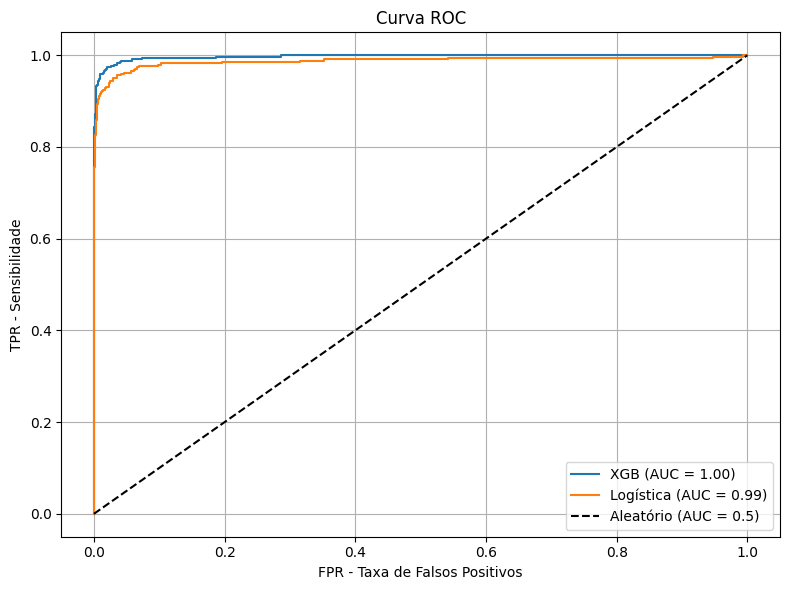

In [303]:
## Curva ROC

# Probabilidades da classe positiva (geralmente a segunda coluna [:,1])
prob_xgb = xgb.predict_proba(X_test_d_select)[:, 1]
prob_log = logistico_model.predict_proba(X_test_d_select)[:, 1]

# Calcular pontos da curva ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, prob_xgb)
fpr_log, tpr_log, _ = roc_curve(y_test, prob_log)

# Calcular AUC
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_log = auc(fpr_log, tpr_log)

# Plot da curva ROC
plot.figure(figsize=(8, 6))
plot.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {auc_xgb:.2f})')
plot.plot(fpr_log, tpr_log, label=f'Logística (AUC = {auc_log:.2f})')
plot.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')
plot.xlabel('FPR - Taxa de Falsos Positivos')
plot.ylabel('TPR - Sensibilidade')
plot.title('Curva ROC')
plot.legend(loc='lower right')
plot.grid()
plot.tight_layout()
plot.show()

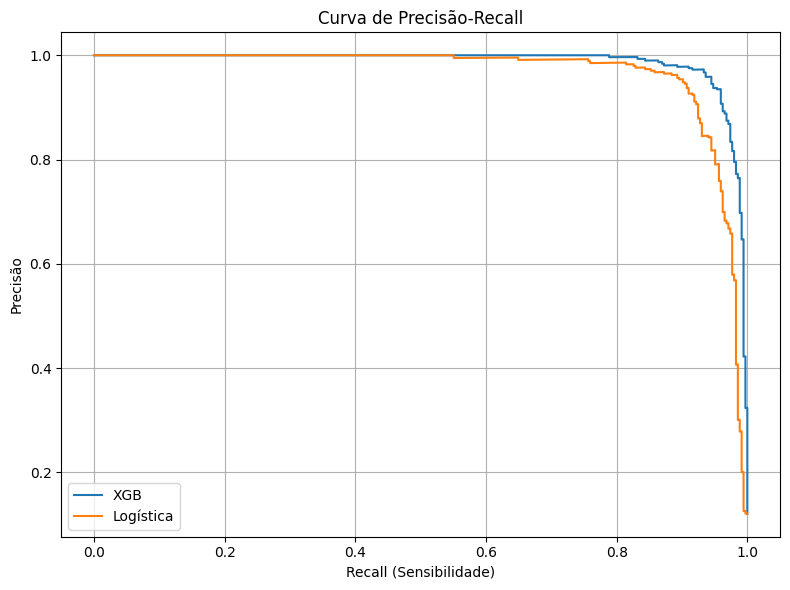

In [304]:
# Calcular pontos da curva Precision-Recall
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, prob_xgb)
prec_log, rec_log, _ = precision_recall_curve(y_test, prob_log)

# Plot da curva Precision-Recall
plot.figure(figsize=(8, 6))
plot.plot(rec_xgb, prec_xgb, label='XGB')
plot.plot(rec_log, prec_log, label='Logística')
plot.xlabel('Recall (Sensibilidade)')
plot.ylabel('Precisão')
plot.title('Curva de Precisão-Recall')
plot.legend(loc='lower left')
plot.grid()
plot.tight_layout()
plot.show()

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_7856\3097376759.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia, x='Importância', y='Variável', palette='viridis')


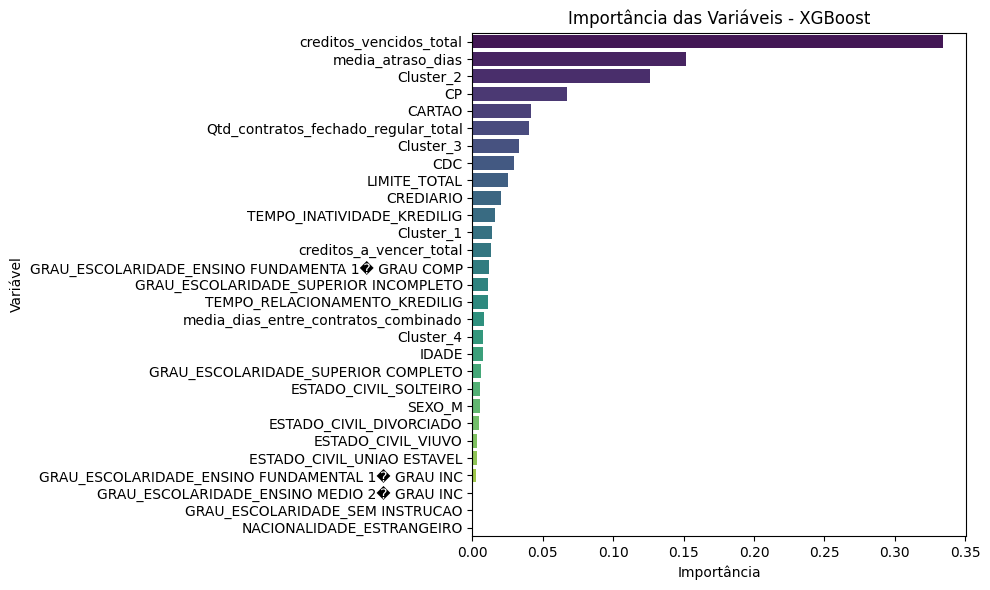

In [305]:
## Gráfico de Importância das Variáveis

importancias = xgb.feature_importances_
nomes_variaveis = X_train_d_select.columns

df_importancia = pd.DataFrame({
    'Variável': nomes_variaveis,
    'Importância': importancias
})

# Ordenar por importância
df_importancia = df_importancia.sort_values(by='Importância', ascending=False)

# Plot
plot.figure(figsize=(10, 6))
sns.barplot(data=df_importancia, x='Importância', y='Variável', palette='viridis')
plot.title('Importância das Variáveis - XGBoost')
plot.xlabel('Importância')
plot.ylabel('Variável')
plot.tight_layout()
plot.show()

In [ ]:
# Pontuação
# Prever classe (0 ou 1)
df_novo=X_test_d_select
df_novo['rótulo_predito'] = xgb.predict(df_novo[X_train_d_select.columns])
df_novo['probabilidade_1'] = xgb.predict_proba(df_novo[X_train_d_select.columns])[:, 1]
df_novo

,IDADE,TEMPO_RELACIONAMENTO_KREDILIG,TEMPO_INATIVIDADE_KREDILIG,LIMITE_TOTAL,CDC,CP,CREDIARIO,CARTAO,Qtd_contratos_fechado_regular_total,media_atraso_dias,...,ESTADO_CIVIL_VIUVO,GRAU_ESCOLARIDADE_ENSINO FUNDAMENTA 1� GRAU COMP,GRAU_ESCOLARIDADE_ENSINO FUNDAMENTAL 1� GRAU INC,GRAU_ESCOLARIDADE_ENSINO MEDIO 2� GRAU INC,GRAU_ESCOLARIDADE_SEM INSTRUCAO,GRAU_ESCOLARIDADE_SUPERIOR COMPLETO,GRAU_ESCOLARIDADE_SUPERIOR INCOMPLETO,NACIONALIDADE_ESTRANGEIRO,rótulo_predito,probabilidade_1
353499,0.26,-0.29,0.35,-0.69,0,0,0,1,-0.38,-0.34,...,0,0,0,0,0,0,0,0,0,0.00
139545,1.32,-0.95,0.18,-0.69,0,0,0,1,-0.71,1.69,...,0,0,0,0,0,0,0,0,0,0.05
180404,0.76,-0.71,-0.65,0.87,0,1,0,0,-0.54,-0.33,...,0,0,0,0,0,1,0,0,0,0.00
154610,0.45,0.53,-0.70,0.87,1,1,1,1,0.62,-0.34,...,0,0,0,0,0,0,0,0,0,0.00
407949,0.38,0.64,-0.65,-0.40,0,0,1,0,-0.71,-0.30,...,0,0,0,0,0,1,0,0,0,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282104,1.01,0.60,-0.72,1.56,1,1,1,1,1.28,-0.32,...,0,0,0,0,0,0,0,0,0,0.01
39638,0.51,-0.02,-0.58,-0.69,0,1,0,1,-0.21,-0.24,...,0,0,0,0,0,0,0,0,1,0.98
204344,1.45,1.10,2.63,-0.69,0,0,0,1,-0.05,-0.34,...,0,0,0,0,0,0,0,0,0,0.00
32374,0.45,-0.35,0.18,0.19,0,0,1,0,-0.54,-0.34,...,0,0,0,0,0,0,0,0,0,0.00


In [ ]:
# Interpretação SHAP

# escore

# limite